# Log-Transformed Spatial Autoregressive Analysis

This notebook applies log transformation to median rent prices before fitting SAR models.

## Motivation
Based on Q-Q plot analysis, median rent prices follow a log-normal distribution. By log-transforming the response variable, we can:
- Satisfy normality assumptions for linear regression
- Handle multiplicative effects naturally
- Stabilize variance across the range of values
- Improve model fit and interpretation

## Objectives
- Transform median rent to log scale
- Fit OLS and WLS models on log-transformed data
- Evaluate model performance
- Back-transform predictions to original scale
- Compare with non-transformed models


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS, WLS
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully")


Libraries loaded successfully


## 1. Load Data and Apply Log Transformation


In [38]:
# Load cleaned dataset from previous SAR analysis
#df_clean = pd.read_pickle('../data/curated/rent_growth/df_clean.pkl')
df_clean = pd.read_csv('../data/curated/rent_growth/df_clean.csv')
# Convert date to datetime if needed
df_clean['date'] = pd.to_datetime(df_clean['date'])

print(f"Dataset loaded successfully")
print(f"Shape: {df_clean.shape}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"\nOriginal median_rent statistics:")
print(df_clean['median_rent'].describe())


Dataset loaded successfully
Shape: (38528, 32)
Date range: 2013-06-01 00:00:00 to 2025-03-01 00:00:00

Original median_rent statistics:
count    38528.000000
mean       455.935190
std        193.352361
min        115.000000
25%        330.000000
50%        405.000000
75%        540.000000
max       1975.000000
Name: median_rent, dtype: float64


In [39]:
# Apply log transformation to median rent
df_clean['log_median_rent'] = np.log(df_clean['median_rent'])

print("=" * 70)
print("LOG TRANSFORMATION APPLIED")
print("=" * 70)
print(f"\nLog-transformed median_rent statistics:")
print(df_clean['log_median_rent'].describe())
print(f"\nOriginal vs Log-transformed:")
print(f"  Original: Mean=${df_clean['median_rent'].mean():.2f}, Std=${df_clean['median_rent'].std():.2f}")
print(f"  Log: Mean={df_clean['log_median_rent'].mean():.4f}, Std={df_clean['log_median_rent'].std():.4f}")
print("=" * 70)


LOG TRANSFORMATION APPLIED

Log-transformed median_rent statistics:
count    38528.000000
mean         6.045501
std          0.384812
min          4.744932
25%          5.799093
50%          6.003887
75%          6.291569
max          7.588324
Name: log_median_rent, dtype: float64

Original vs Log-transformed:
  Original: Mean=$455.94, Std=$193.35
  Log: Mean=6.0455, Std=0.3848


In [40]:
# Also transform the lagged rent variables
print("\nTransforming lagged rent variables to log scale...")
for lag in range(1, 5):
    df_clean[f'log_rent_lag_{lag}'] = np.log(df_clean[f'rent_lag_{lag}'])
    print(f"  Created log_rent_lag_{lag}")

# Also transform spatial lag
df_clean['log_spatial_lag'] = np.log(df_clean['spatial_lag'] + 1e-10)  # Add small constant to avoid log(0)
print(f"  Created log_spatial_lag")

print("\nAll variables transformed to log scale")



Transforming lagged rent variables to log scale...
  Created log_rent_lag_1
  Created log_rent_lag_2
  Created log_rent_lag_3
  Created log_rent_lag_4
  Created log_spatial_lag

All variables transformed to log scale


## 2. Verify Normality of Log-Transformed Data


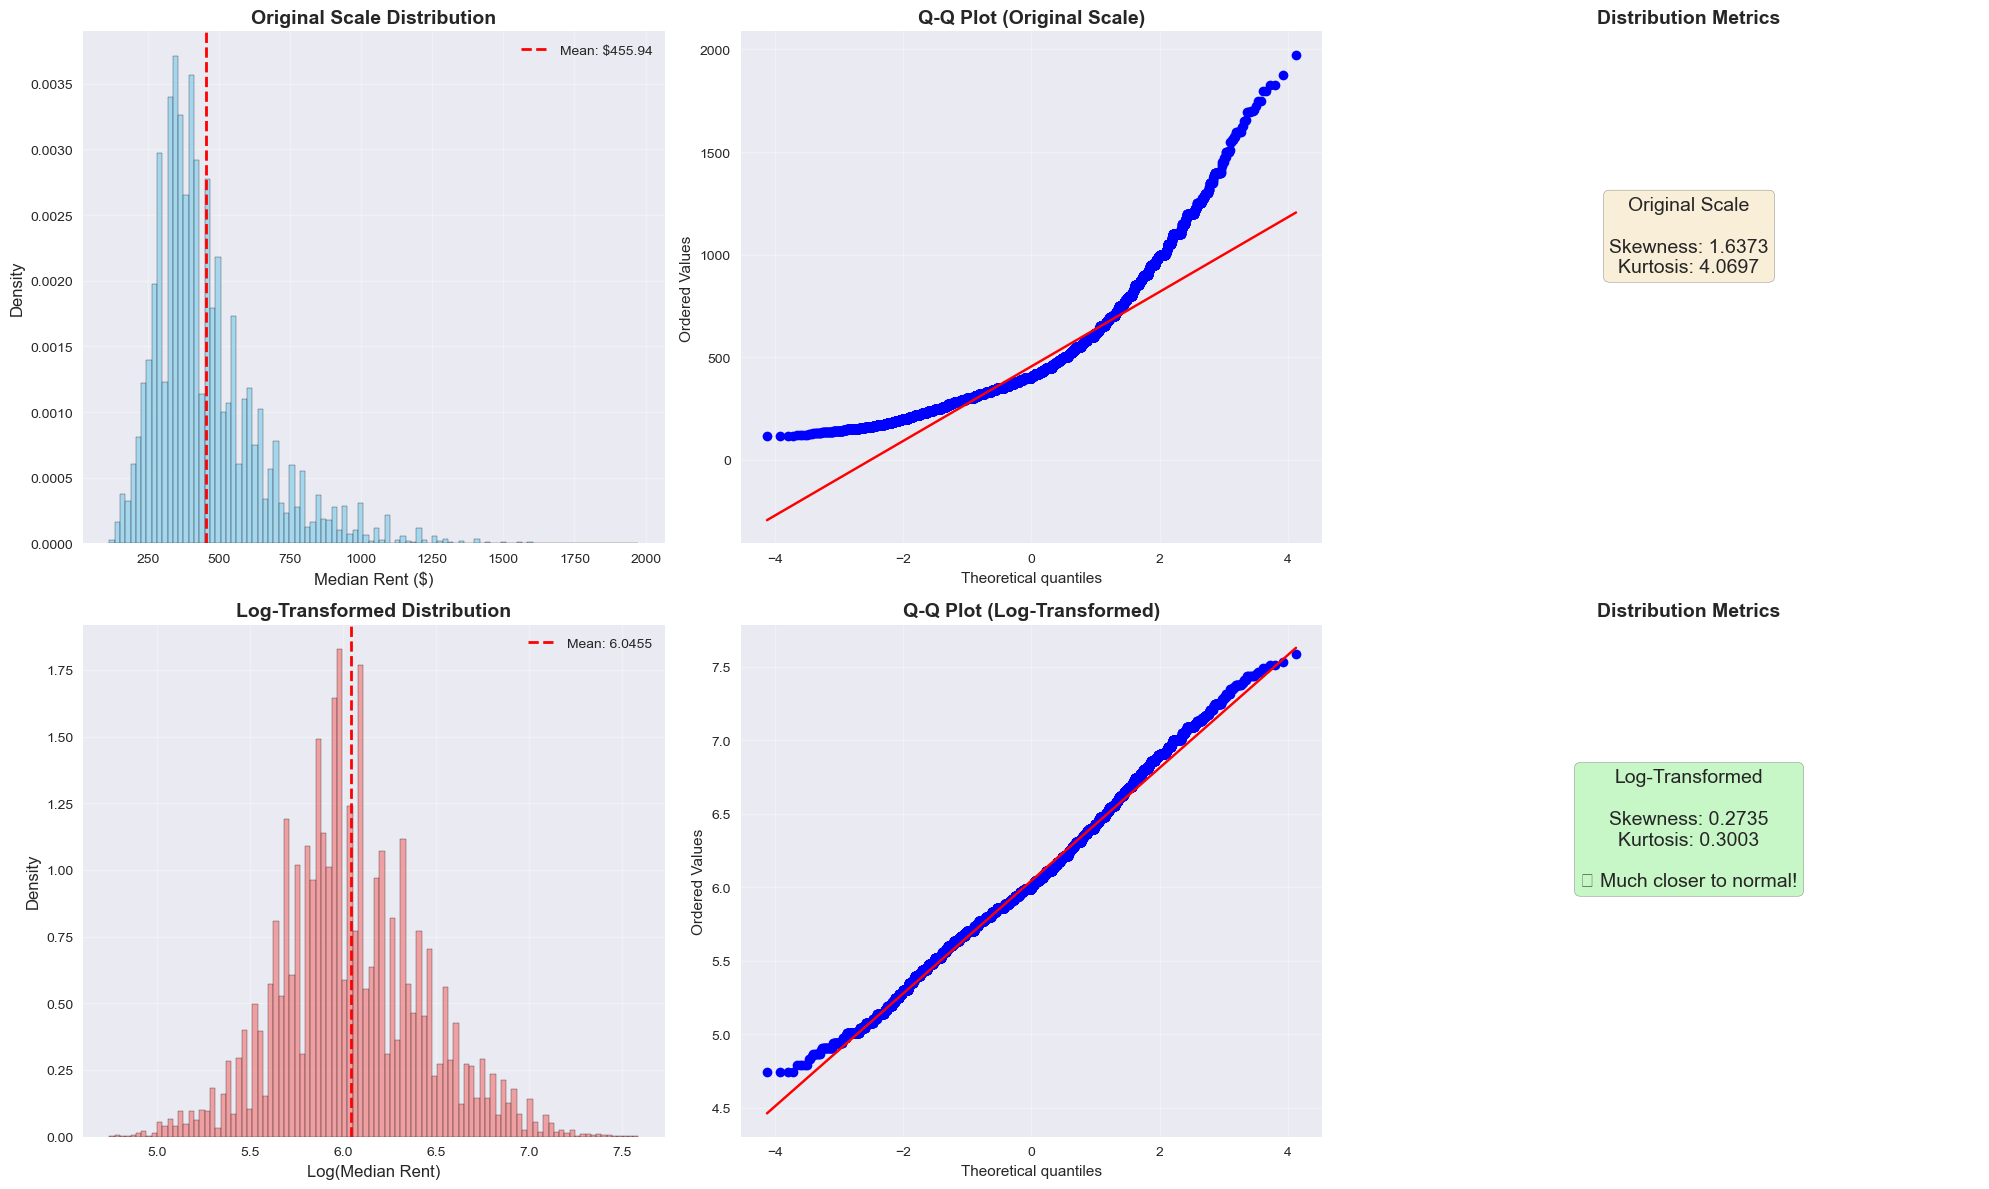

NORMALITY IMPROVEMENT
Original scale:
  Skewness: 1.6373 → Log scale: 0.2735
  Kurtosis: 4.0697 → Log scale: 0.3003

✓ Log transformation brings distribution much closer to normal!


In [42]:
# Compare distributions before and after log transformation
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Original scale
y_original = df_clean['median_rent'].values

# Plot 1: Original histogram
axes[0, 0].hist(y_original, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(y_original.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${y_original.mean():.2f}')
axes[0, 0].set_xlabel('Median Rent ($)', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Original Scale Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Original Q-Q plot
stats.probplot(y_original, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Original Scale)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Original skewness/kurtosis
skew_orig = stats.skew(y_original)
kurt_orig = stats.kurtosis(y_original)
axes[0, 2].text(0.5, 0.6, f'Original Scale\n\nSkewness: {skew_orig:.4f}\nKurtosis: {kurt_orig:.4f}', 
               ha='center', va='center', fontsize=14, transform=axes[0, 2].transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[0, 2].set_title('Distribution Metrics', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Log-transformed scale
y_log = df_clean['log_median_rent'].values

# Plot 4: Log histogram
axes[1, 0].hist(y_log, bins=100, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(y_log.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_log.mean():.4f}')
axes[1, 0].set_xlabel('Log(Median Rent)', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Log-Transformed Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Log Q-Q plot
stats.probplot(y_log, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Log-Transformed)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Log skewness/kurtosis
skew_log = stats.skew(y_log)
kurt_log = stats.kurtosis(y_log)
axes[1, 2].text(0.5, 0.6, f'Log-Transformed\n\nSkewness: {skew_log:.4f}\nKurtosis: {kurt_log:.4f}\n\n✓ Much closer to normal!', 
               ha='center', va='center', fontsize=14, transform=axes[1, 2].transAxes,
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[1, 2].set_title('Distribution Metrics', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("=" * 70)
print("NORMALITY IMPROVEMENT")
print("=" * 70)
print(f"Original scale:")
print(f"  Skewness: {skew_orig:.4f} → Log scale: {skew_log:.4f}")
print(f"  Kurtosis: {kurt_orig:.4f} → Log scale: {kurt_log:.4f}")
print(f"\n✓ Log transformation brings distribution much closer to normal!")
print("=" * 70)


## 3. Feature Engineering - One-Hot Encode Property Type


In [44]:
# One-hot encode property_type
print("One-hot encoding property_type...")
property_dummies = pd.get_dummies(df_clean['property_type'], prefix='property', dtype=np.float64)

# Add to dataframe
df_clean = pd.concat([df_clean, property_dummies], axis=1)

# Ensure property dummies are float64
for col in property_dummies.columns:
    df_clean[col] = df_clean[col].astype(np.float64)

print(f"Created {len(property_dummies.columns)} property type dummy variables:")
print(f"  {list(property_dummies.columns)}")
print(f"\nProperty type distribution:")
print(df_clean['property_type'].value_counts())


One-hot encoding property_type...
Created 6 property type dummy variables:
  ['property_1 bedroom flat', 'property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']

Property type distribution:
property_type
2 bedroom flat     6584
3 bedroom house    6534
4 bedroom house    6452
3 bedroom flat     6394
2 bedroom house    6390
1 bedroom flat     6174
Name: count, dtype: int64


In [45]:
# Clean data: check for and handle NaN/Inf values
print("\n" + "=" * 70)
print("DATA CLEANING: Checking for NaN and Inf values...")
print("=" * 70)

# Check log-transformed features for NaN/Inf
log_features_to_check = ['log_median_rent', 'log_rent_lag_1', 'log_rent_lag_2', 
                         'log_rent_lag_3', 'log_rent_lag_4', 'log_spatial_lag']

for feat in log_features_to_check:
    if feat in df_clean.columns:
        nan_count = df_clean[feat].isna().sum()
        inf_count = np.isinf(df_clean[feat]).sum()
        if nan_count > 0 or inf_count > 0:
            print(f"  {feat}: {nan_count} NaN, {inf_count} Inf values")

# For spatial_lag, handle zeros and NaNs properly
# Replace -Inf values from log(0) with a reasonable minimum
if 'log_spatial_lag' in df_clean.columns:
    # Replace -Inf with NaN first
    df_clean['log_spatial_lag'] = df_clean['log_spatial_lag'].replace([np.inf, -np.inf], np.nan)
    
    # For rows where spatial_lag was 0 or missing, impute with 0 (neutral effect)
    # This is reasonable since missing spatial lag means no spatial spillover
    df_clean['log_spatial_lag'] = df_clean['log_spatial_lag'].fillna(0)
    
print("\n✓ Cleaned log_spatial_lag by replacing -Inf/NaN with 0")

# Drop any remaining rows with NaN in log features (these would be from original NaN rent values)
before_drop = len(df_clean)
df_clean = df_clean.dropna(subset=log_features_to_check)
after_drop = len(df_clean)

if before_drop > after_drop:
    print(f"\n✓ Dropped {before_drop - after_drop} rows with NaN in log-transformed features")
else:
    print(f"\n✓ No rows dropped - all data is clean")

print(f"\nFinal dataset shape: {df_clean.shape}")
print("=" * 70)



DATA CLEANING: Checking for NaN and Inf values...

✓ Cleaned log_spatial_lag by replacing -Inf/NaN with 0

✓ No rows dropped - all data is clean

Final dataset shape: (38528, 44)


## 4. Data Preparation for Modeling


In [47]:
# Define feature sets for log-scale modeling
log_lag_features = ['log_rent_lag_1', 'log_rent_lag_2', 'log_rent_lag_3', 'log_rent_lag_4']
log_spatial_features = ['log_spatial_lag']
economic_features = ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 
                    'population', 'median_personal_income']
property_features = list(property_dummies.columns)

# Combine all features
all_features = log_lag_features + log_spatial_features + economic_features + property_features

print(f"Features for log-scale SAR modeling ({len(all_features)}):")
print(f"  Log lag features: {log_lag_features}")
print(f"  Log spatial features: {log_spatial_features}")
print(f"  Economic features: {economic_features}")
print(f"  Property type features: {property_features}")


Features for log-scale SAR modeling (17):
  Log lag features: ['log_rent_lag_1', 'log_rent_lag_2', 'log_rent_lag_3', 'log_rent_lag_4']
  Log spatial features: ['log_spatial_lag']
  Economic features: ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population', 'median_personal_income']
  Property type features: ['property_1 bedroom flat', 'property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']


In [48]:
# Temporal train/test split
split_date = pd.to_datetime('2024-01-01')

df_train = df_clean[df_clean['date'] < split_date].copy()
df_test = df_clean[df_clean['date'] >= split_date].copy()

print("=" * 70)
print("TEMPORAL TRAIN/TEST SPLIT")
print("=" * 70)
print(f"\nSplit date: {split_date.date()}")
print(f"\nTrain set: {len(df_train)} observations ({100*len(df_train)/len(df_clean):.1f}%)")
print(f"  Date range: {df_train['date'].min().date()} to {df_train['date'].max().date()}")
print(f"  Log median rent: {df_train['log_median_rent'].mean():.4f} ± {df_train['log_median_rent'].std():.4f}")
print(f"\nTest set: {len(df_test)} observations ({100*len(df_test)/len(df_clean):.1f}%)")
print(f"  Date range: {df_test['date'].min().date()} to {df_test['date'].max().date()}")
print(f"  Log median rent: {df_test['log_median_rent'].mean():.4f} ± {df_test['log_median_rent'].std():.4f}")
print("=" * 70)


TEMPORAL TRAIN/TEST SPLIT

Split date: 2024-01-01

Train set: 34180 observations (88.7%)
  Date range: 2013-06-01 to 2023-12-01
  Log median rent: 6.0140 ± 0.3785

Test set: 4348 observations (11.3%)
  Date range: 2024-03-01 to 2025-03-01
  Log median rent: 6.2932 ± 0.3413


In [49]:
# Validate features before creating matrices
print("=" * 70)
print("FEATURE VALIDATION")
print("=" * 70)

# Check that all features exist
missing_features = [f for f in all_features if f not in df_train.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    # Remove missing features from all_features
    all_features = [f for f in all_features if f in df_train.columns]
    print(f"✓ Updated feature list to exclude missing features")

# Check data types
print(f"\nChecking data types for {len(all_features)} features...")
non_numeric = []
for feat in all_features:
    print(feat)
    if not pd.api.types.is_numeric_dtype(df_train[feat]):
        non_numeric.append((feat, df_train[feat].dtype))

if non_numeric:
    print(f"⚠️  Non-numeric features found:")
    for feat, dtype in non_numeric:
        print(f"    {feat}: {dtype}")
    # Convert to numeric or remove
    for feat, _ in non_numeric:
        df_train[feat] = pd.to_numeric(df_train[feat], errors='coerce')
        df_test[feat] = pd.to_numeric(df_test[feat], errors='coerce')
    print(f"✓ Converted non-numeric features to numeric")
else:
    print(f"✓ All features are numeric")

# Check for NaN/Inf in features
print(f"\nChecking for NaN/Inf in feature columns...")
for feat in all_features:
    nan_train = df_train[feat].isna().sum()
    inf_train = np.isinf(df_train[feat]).sum()
    if nan_train > 0 or inf_train > 0:
        print(f"  {feat}: {nan_train} NaN, {inf_train} Inf in train")

print("=" * 70)

# Prepare data matrices for LOG-SCALE modeling
# IMPORTANT: Convert to float64 explicitly to avoid dtype issues
X_train = df_train[all_features].astype(np.float64).values
y_train_log = df_train['log_median_rent'].astype(np.float64).values  # LOG-TRANSFORMED TARGET
y_train_original = df_train['median_rent'].astype(np.float64).values  # Keep original for comparison
w_train = df_train['weights'].astype(np.float64).values
X_train_const = sm.add_constant(X_train, has_constant='add')

X_test = df_test[all_features].astype(np.float64).values
y_test_log = df_test['log_median_rent'].astype(np.float64).values  # LOG-TRANSFORMED TARGET
y_test_original = df_test['median_rent'].astype(np.float64).values  # Keep original for comparison
w_test = df_test['weights'].astype(np.float64).values
X_test_const = sm.add_constant(X_test, has_constant='add')

print("\n" + "=" * 70)
print("DATA PREPARATION FOR LOG-SCALE MODELING")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  Feature matrix shape: {X_train_const.shape}")
print(f"  Feature matrix dtype: {X_train_const.dtype}")
print(f"  Log target shape: {y_train_log.shape}")
print(f"  Log target stats: Mean={y_train_log.mean():.4f}, Std={y_train_log.std():.4f}")
print(f"  Weights shape: {w_train.shape}")

print(f"\nTest Set:")
print(f"  Feature matrix shape: {X_test_const.shape}")
print(f"  Feature matrix dtype: {X_test_const.dtype}")
print(f"  Log target shape: {y_test_log.shape}")
print(f"  Log target stats: Mean={y_test_log.mean():.4f}, Std={y_test_log.std():.4f}")
print(f"  Weights shape: {w_test.shape}")

print(f"\nFeatures ({len(all_features)}): {all_features[:10]}... (showing first 10)")

# Final validation: check for NaN/Inf in feature matrices
print(f"\nFinal Feature Matrix Validation:")
nan_count_train = np.isnan(X_train_const).sum()
inf_count_train = np.isinf(X_train_const).sum()
print(f"  Train: {nan_count_train} NaN, {inf_count_train} Inf values")

if nan_count_train > 0 or inf_count_train > 0:
    print(f"  ⚠️  WARNING: Found NaN/Inf in training matrix!")
    # Find which features have problems
    for i, feat in enumerate(['const'] + all_features):
        col_nan = np.isnan(X_train_const[:, i]).sum()
        col_inf = np.isinf(X_train_const[:, i]).sum()
        if col_nan > 0 or col_inf > 0:
            print(f"    Feature '{feat}' (col {i}): {col_nan} NaN, {col_inf} Inf")
else:
    print(f"  ✓ No NaN/Inf in feature matrices")

print("=" * 70)


FEATURE VALIDATION

Checking data types for 17 features...
log_rent_lag_1
log_rent_lag_2
log_rent_lag_3
log_rent_lag_4
log_spatial_lag
cpi
unemployment_rate
mortgage_rates
gsp
population
median_personal_income
property_1 bedroom flat
property_2 bedroom flat
property_2 bedroom house
property_3 bedroom flat
property_3 bedroom house
property_4 bedroom house
✓ All features are numeric

Checking for NaN/Inf in feature columns...

DATA PREPARATION FOR LOG-SCALE MODELING

Training Set:
  Feature matrix shape: (34180, 18)
  Feature matrix dtype: float64
  Log target shape: (34180,)
  Log target stats: Mean=6.0140, Std=0.3785
  Weights shape: (34180,)

Test Set:
  Feature matrix shape: (4348, 18)
  Feature matrix dtype: float64
  Log target shape: (4348,)
  Log target stats: Mean=6.2932, Std=0.3413
  Weights shape: (4348,)

Features (17): ['log_rent_lag_1', 'log_rent_lag_2', 'log_rent_lag_3', 'log_rent_lag_4', 'log_spatial_lag', 'cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population']

## 5. Fit Models on Log-Transformed Data


In [51]:
print("=" * 80)
print("FITTING MODELS ON LOG-TRANSFORMED DATA")
print("=" * 80)

# 1. OLS on log scale
print("\n1. Fitting OLS model on log(median_rent)...")
ols_log_model = sm.OLS(y_train_log, X_train_const).fit()

# Train predictions (log scale)
ols_log_train_pred_log = ols_log_model.predict(X_train_const)
# Back-transform to original scale
ols_log_train_pred = np.exp(ols_log_train_pred_log)

# Evaluate on original scale
ols_log_train_r2 = r2_score(y_train_original, ols_log_train_pred)
ols_log_train_rmse = np.sqrt(mean_squared_error(y_train_original, ols_log_train_pred))
ols_log_train_mae = mean_absolute_error(y_train_original, ols_log_train_pred)

# Test predictions (log scale)
ols_log_test_pred_log = ols_log_model.predict(X_test_const)
# Back-transform to original scale
ols_log_test_pred = np.exp(ols_log_test_pred_log)

# Evaluate on original scale
ols_log_test_r2 = r2_score(y_test_original, ols_log_test_pred)
ols_log_test_rmse = np.sqrt(mean_squared_error(y_test_original, ols_log_test_pred))
ols_log_test_mae = mean_absolute_error(y_test_original, ols_log_test_pred)

print(f"   Train (original scale): R²={ols_log_train_r2:.4f}, RMSE=${ols_log_train_rmse:.2f}, MAE=${ols_log_train_mae:.2f}")
print(f"   Test (original scale):  R²={ols_log_test_r2:.4f}, RMSE=${ols_log_test_rmse:.2f}, MAE=${ols_log_test_mae:.2f}")

# 2. WLS on log scale
print("\n2. Fitting WLS model on log(median_rent)...")
wls_log_model = WLS(y_train_log, X_train_const, weights=w_train).fit()

# Train predictions (log scale)
wls_log_train_pred_log = wls_log_model.predict(X_train_const)
# Back-transform to original scale
wls_log_train_pred = np.exp(wls_log_train_pred_log)

# Evaluate on original scale
wls_log_train_r2 = r2_score(y_train_original, wls_log_train_pred)
wls_log_train_rmse = np.sqrt(mean_squared_error(y_train_original, wls_log_train_pred))
wls_log_train_mae = mean_absolute_error(y_train_original, wls_log_train_pred)

# Test predictions (log scale)
wls_log_test_pred_log = wls_log_model.predict(X_test_const)
# Back-transform to original scale
wls_log_test_pred = np.exp(wls_log_test_pred_log)

# Evaluate on original scale
wls_log_test_r2 = r2_score(y_test_original, wls_log_test_pred)
wls_log_test_rmse = np.sqrt(mean_squared_error(y_test_original, wls_log_test_pred))
wls_log_test_mae = mean_absolute_error(y_test_original, wls_log_test_pred)

print(f"   Train (original scale): R²={wls_log_train_r2:.4f}, RMSE=${wls_log_train_rmse:.2f}, MAE=${wls_log_train_mae:.2f}")
print(f"   Test (original scale):  R²={wls_log_test_r2:.4f}, RMSE=${wls_log_test_rmse:.2f}, MAE=${wls_log_test_mae:.2f}")

print("\n" + "=" * 80)
print("MODELS FITTED SUCCESSFULLY ON LOG SCALE")
print("=" * 80)


FITTING MODELS ON LOG-TRANSFORMED DATA

1. Fitting OLS model on log(median_rent)...
   Train (original scale): R²=0.9928, RMSE=$15.62, MAE=$8.04
   Test (original scale):  R²=0.9903, RMSE=$21.47, MAE=$12.69

2. Fitting WLS model on log(median_rent)...
   Train (original scale): R²=0.9928, RMSE=$15.63, MAE=$8.08
   Test (original scale):  R²=0.9900, RMSE=$21.82, MAE=$13.18

MODELS FITTED SUCCESSFULLY ON LOG SCALE


## 6. Model Comparison


In [53]:
# Model comparison summary
print("=" * 80)
print("MODEL COMPARISON SUMMARY - TRAIN vs TEST PERFORMANCE")
print("=" * 80)

print("\n" + "=" * 80)
print("TRAINING SET PERFORMANCE (In-Sample, Original Scale)")
print("=" * 80)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 80)
print(f"{'OLS (Log)':<20} {ols_log_train_r2:<12.4f} ${ols_log_train_rmse:<11.2f} ${ols_log_train_mae:<11.2f}")
print(f"{'WLS (Log)':<20} {wls_log_train_r2:<12.4f} ${wls_log_train_rmse:<11.2f} ${wls_log_train_mae:<11.2f}")
print("=" * 80)

print("\n" + "=" * 80)
print("TEST SET PERFORMANCE (Out-of-Sample, Original Scale)")
print("=" * 80)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 80)
print(f"{'OLS (Log)':<20} {ols_log_test_r2:<12.4f} ${ols_log_test_rmse:<11.2f} ${ols_log_test_mae:<11.2f}")
print(f"{'WLS (Log)':<20} {wls_log_test_r2:<12.4f} ${wls_log_test_rmse:<11.2f} ${wls_log_test_mae:<11.2f}")
print("=" * 80)

# Calculate performance degradation
print("\n" + "=" * 80)
print("GENERALIZATION GAP (Train R² - Test R²)")
print("=" * 80)
ols_log_gap = ols_log_train_r2 - ols_log_test_r2
wls_log_gap = wls_log_train_r2 - wls_log_test_r2
print(f"{'Model':<20} {'Train R²':<12} {'Test R²':<12} {'Gap':<12} {'Gap %':<12}")
print("-" * 80)
print(f"{'OLS (Log)':<20} {ols_log_train_r2:<12.4f} {ols_log_test_r2:<12.4f} {ols_log_gap:<12.4f} {100*ols_log_gap/ols_log_train_r2:<11.2f}%")
print(f"{'WLS (Log)':<20} {wls_log_train_r2:<12.4f} {wls_log_test_r2:<12.4f} {wls_log_gap:<12.4f} {100*wls_log_gap/wls_log_train_r2:<11.2f}%")
print("=" * 80)

if ols_log_gap > 0.05 or wls_log_gap > 0.05:
    print("\n⚠️  WARNING: Significant generalization gap detected (>5%). Model may be overfitting.")
else:
    print("\n✓ Good generalization: Both models perform similarly on train and test sets.")


MODEL COMPARISON SUMMARY - TRAIN vs TEST PERFORMANCE

TRAINING SET PERFORMANCE (In-Sample, Original Scale)
Model                R²           RMSE         MAE         
--------------------------------------------------------------------------------
OLS (Log)            0.9928       $15.62       $8.04       
WLS (Log)            0.9928       $15.63       $8.08       

TEST SET PERFORMANCE (Out-of-Sample, Original Scale)
Model                R²           RMSE         MAE         
--------------------------------------------------------------------------------
OLS (Log)            0.9903       $21.47       $12.69      
WLS (Log)            0.9900       $21.82       $13.18      

GENERALIZATION GAP (Train R² - Test R²)
Model                Train R²     Test R²      Gap          Gap %       
--------------------------------------------------------------------------------
OLS (Log)            0.9928       0.9903       0.0025       0.25       %
WLS (Log)            0.9928       0.9900       0.

## 7. Model Diagnostics and Visualization


In [55]:
# OLS model summary
print("=" * 80)
print("OLS MODEL SUMMARY (Log Scale)")
print("=" * 80)
print(ols_log_model.summary())


OLS MODEL SUMMARY (Log Scale)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.184e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:51:09   Log-Likelihood:                 74991.
No. Observations:               34180   AIC:                        -1.499e+05
Df Residuals:                   34163   BIC:                        -1.498e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0623 

In [56]:
# WLS model summary
print("=" * 80)
print("WLS MODEL SUMMARY (Log Scale)")
print("=" * 80)
print(wls_log_model.summary())


WLS MODEL SUMMARY (Log Scale)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            WLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.424e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:51:10   Log-Likelihood:                 70943.
No. Observations:               34180   AIC:                        -1.419e+05
Df Residuals:                   34163   BIC:                        -1.417e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0394 

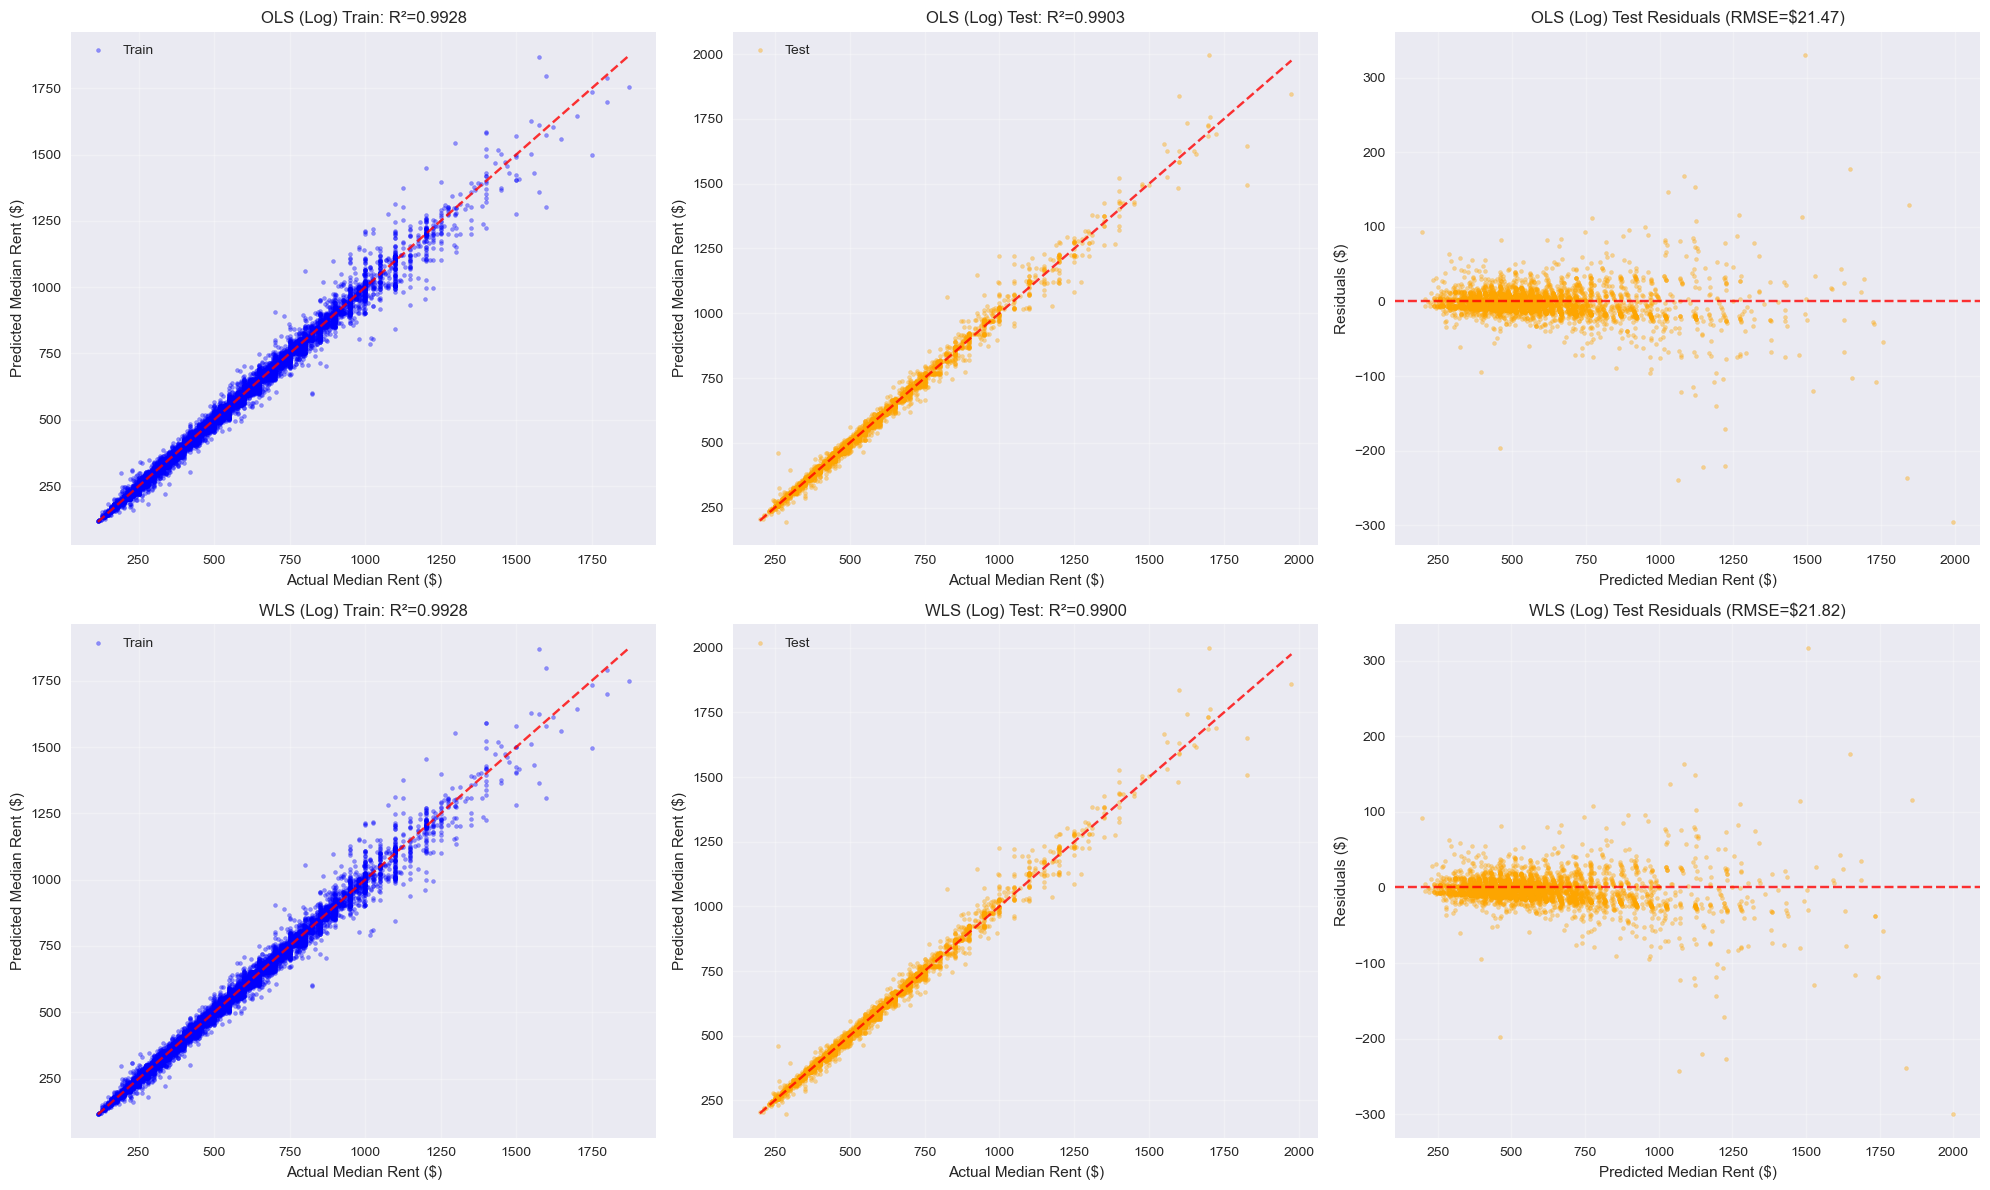

In [57]:
# Residual analysis for TEST set (original scale)
ols_log_test_residuals = y_test_original - ols_log_test_pred
wls_log_test_residuals = y_test_original - wls_log_test_pred

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: OLS
# Plot 1: OLS Train - Actual vs Predicted
axes[0, 0].scatter(y_train_original, ols_log_train_pred, alpha=0.4, s=8, color='blue', label='Train')
axes[0, 0].plot([y_train_original.min(), y_train_original.max()], 
                [y_train_original.min(), y_train_original.max()], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Actual Median Rent ($)')
axes[0, 0].set_ylabel('Predicted Median Rent ($)')
axes[0, 0].set_title(f'OLS (Log) Train: R²={ols_log_train_r2:.4f}', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: OLS Test - Actual vs Predicted
axes[0, 1].scatter(y_test_original, ols_log_test_pred, alpha=0.4, s=8, color='orange', label='Test')
axes[0, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--', alpha=0.8)
axes[0, 1].set_xlabel('Actual Median Rent ($)')
axes[0, 1].set_ylabel('Predicted Median Rent ($)')
axes[0, 1].set_title(f'OLS (Log) Test: R²={ols_log_test_r2:.4f}', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: OLS Test Residuals
axes[0, 2].scatter(ols_log_test_pred, ols_log_test_residuals, alpha=0.4, s=8, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 2].set_xlabel('Predicted Median Rent ($)')
axes[0, 2].set_ylabel('Residuals ($)')
axes[0, 2].set_title(f'OLS (Log) Test Residuals (RMSE=${ols_log_test_rmse:.2f})', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: WLS
# Plot 4: WLS Train - Actual vs Predicted
axes[1, 0].scatter(y_train_original, wls_log_train_pred, alpha=0.4, s=8, color='blue', label='Train')
axes[1, 0].plot([y_train_original.min(), y_train_original.max()], 
                [y_train_original.min(), y_train_original.max()], 'r--', alpha=0.8)
axes[1, 0].set_xlabel('Actual Median Rent ($)')
axes[1, 0].set_ylabel('Predicted Median Rent ($)')
axes[1, 0].set_title(f'WLS (Log) Train: R²={wls_log_train_r2:.4f}', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: WLS Test - Actual vs Predicted
axes[1, 1].scatter(y_test_original, wls_log_test_pred, alpha=0.4, s=8, color='orange', label='Test')
axes[1, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--', alpha=0.8)
axes[1, 1].set_xlabel('Actual Median Rent ($)')
axes[1, 1].set_ylabel('Predicted Median Rent ($)')
axes[1, 1].set_title(f'WLS (Log) Test: R²={wls_log_test_r2:.4f}', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: WLS Test Residuals
axes[1, 2].scatter(wls_log_test_pred, wls_log_test_residuals, alpha=0.4, s=8, color='orange')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_xlabel('Predicted Median Rent ($)')
axes[1, 2].set_ylabel('Residuals ($)')
axes[1, 2].set_title(f'WLS (Log) Test Residuals (RMSE=${wls_log_test_rmse:.2f})', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


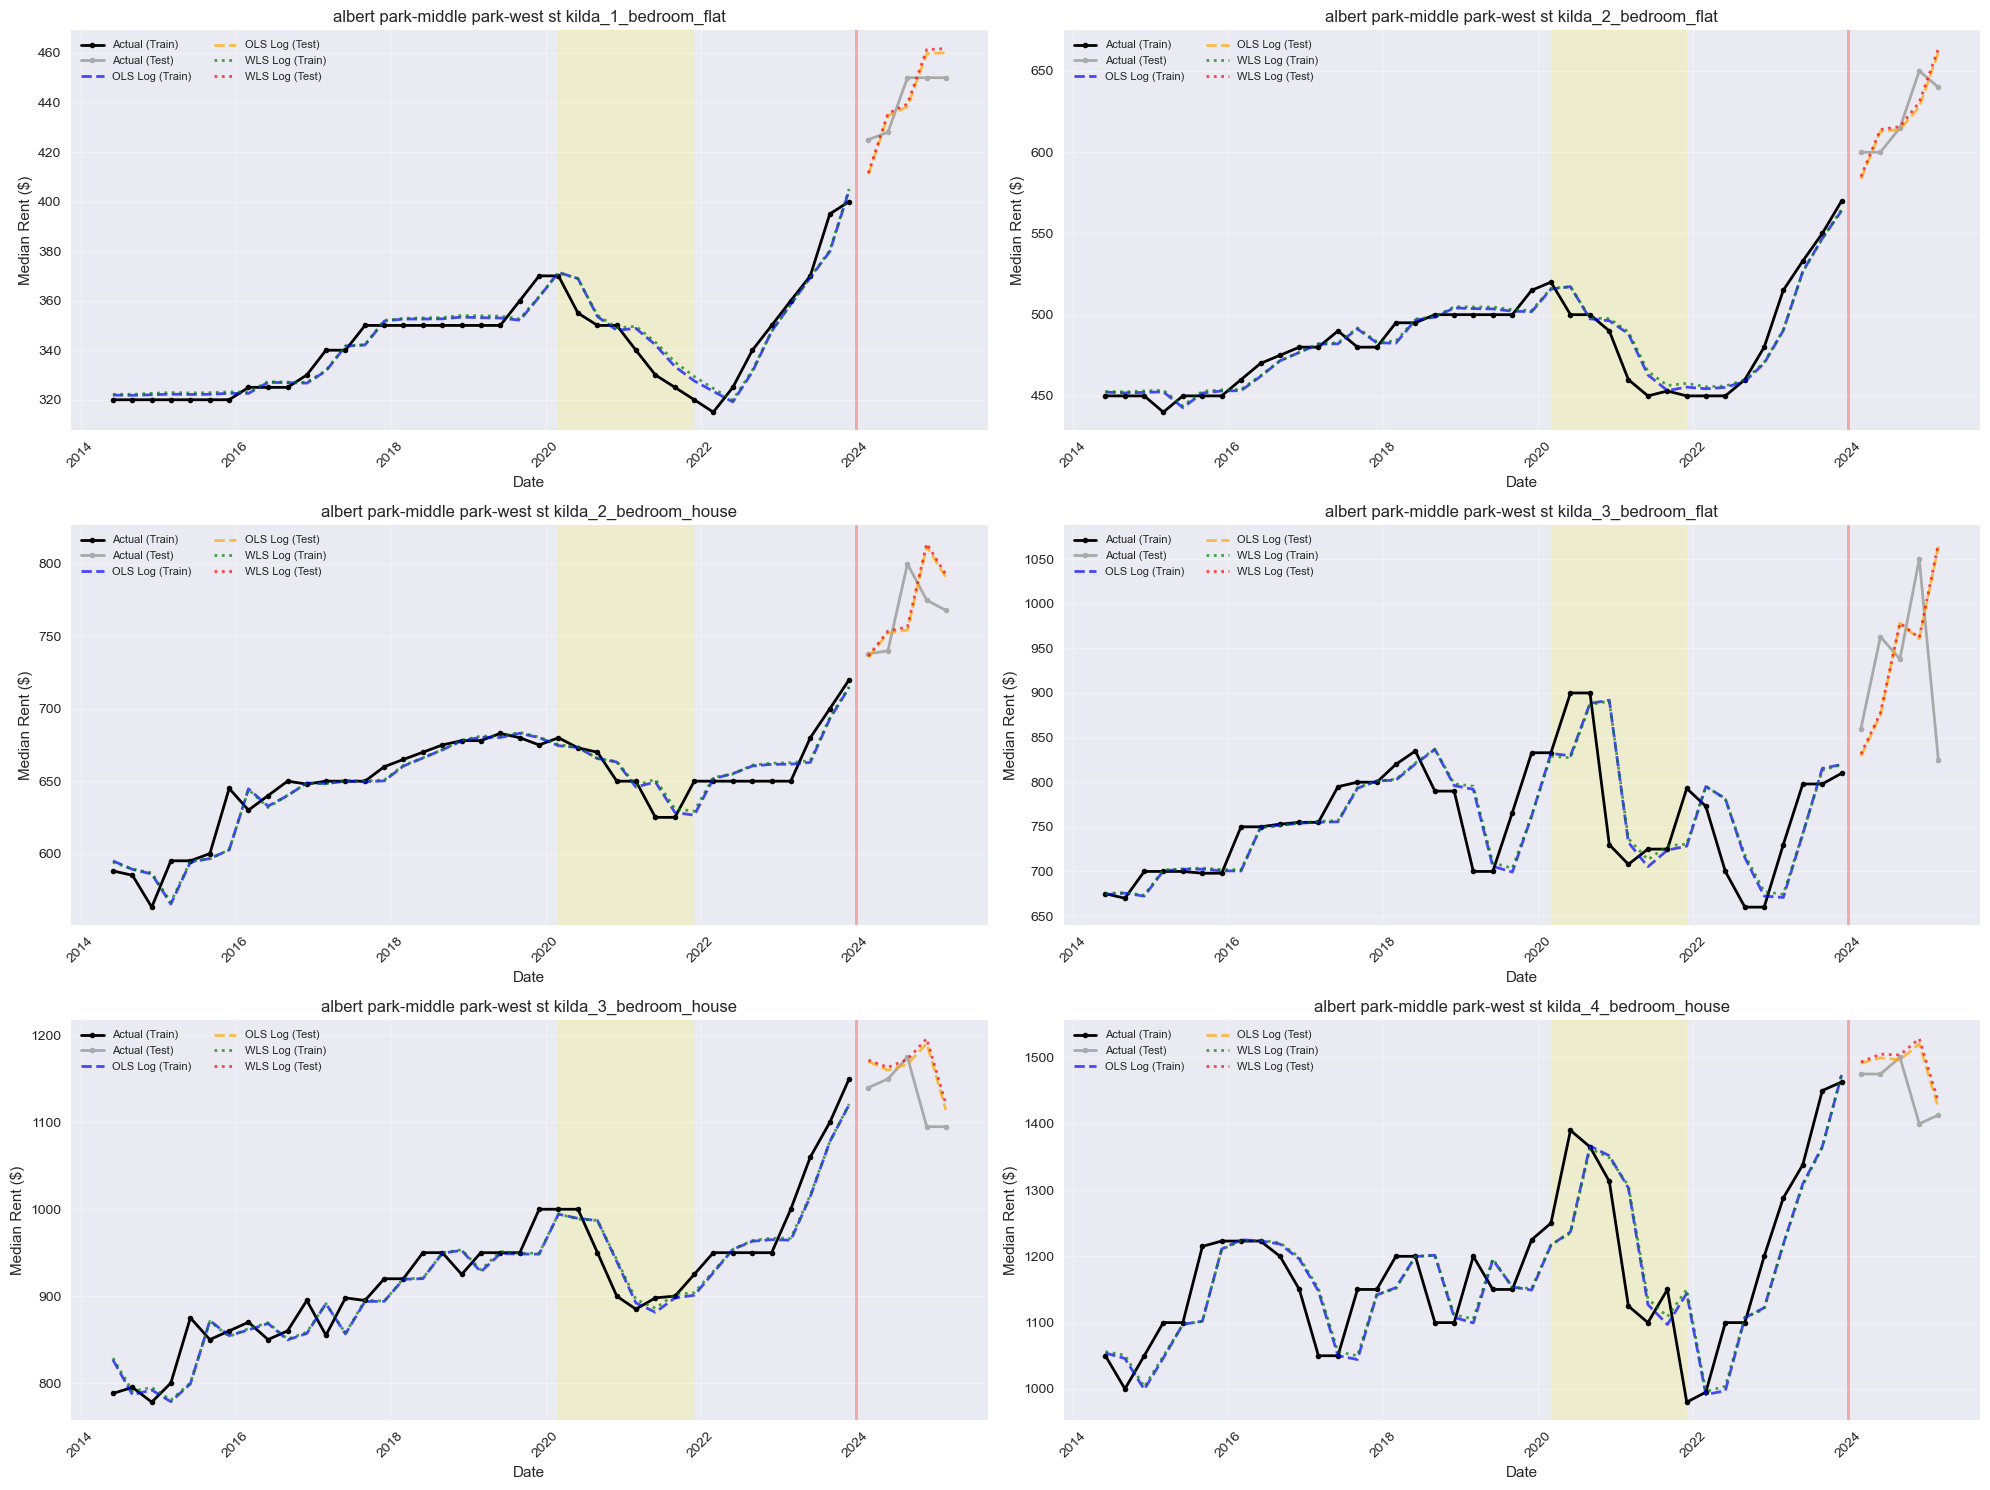

In [58]:
# Time series predictions for sample units
sample_units = df_clean['spatial_unit'].unique()[:6]

# Combine train and test predictions
df_train['ols_log_pred'] = ols_log_train_pred
df_train['wls_log_pred'] = wls_log_train_pred
df_test['ols_log_pred'] = ols_log_test_pred
df_test['wls_log_pred'] = wls_log_test_pred

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, unit in enumerate(sample_units):
    # Get train and test data for this unit
    unit_train = df_train[df_train['spatial_unit'] == unit]
    unit_test = df_test[df_test['spatial_unit'] == unit]
    
    # Plot actual values
    axes[i].plot(unit_train['date'], unit_train['median_rent'], 
                'o-', color='black', label='Actual (Train)', linewidth=2, markersize=4)
    axes[i].plot(unit_test['date'], unit_test['median_rent'], 
                'o-', color='darkgray', label='Actual (Test)', linewidth=2, markersize=4)
    
    # Plot OLS predictions
    axes[i].plot(unit_train['date'], unit_train['ols_log_pred'], 
                '--', color='blue', label='OLS Log (Train)', linewidth=2, alpha=0.7)
    if not unit_test.empty:
        axes[i].plot(unit_test['date'], unit_test['ols_log_pred'], 
                    '--', color='orange', label='OLS Log (Test)', linewidth=2, alpha=0.7)
    
    # Plot WLS predictions
    axes[i].plot(unit_train['date'], unit_train['wls_log_pred'], 
                ':', color='green', label='WLS Log (Train)', linewidth=2, alpha=0.7)
    if not unit_test.empty:
        axes[i].plot(unit_test['date'], unit_test['wls_log_pred'], 
                    ':', color='red', label='WLS Log (Test)', linewidth=2, alpha=0.7)
    
    # Add vertical line at train/test split
    axes[i].axvline(x=split_date, color='red', linestyle='-', linewidth=2, alpha=0.3)
    
    # Highlight unreliable period
    unreliable_mask_train = unit_train['is_unreliable']
    if unreliable_mask_train.any():
        unreliable_dates_train = unit_train[unreliable_mask_train]['date']
        axes[i].axvspan(unreliable_dates_train.min(), unreliable_dates_train.max(), 
                       alpha=0.15, color='yellow', zorder=0)
    
    axes[i].set_title(unit, fontsize=12)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Median Rent ($)')
    axes[i].legend(loc='best', fontsize=8, ncol=2)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Clean up temporary columns
df_train.drop(['ols_log_pred', 'wls_log_pred'], axis=1, inplace=True)
df_test.drop(['ols_log_pred', 'wls_log_pred'], axis=1, inplace=True)


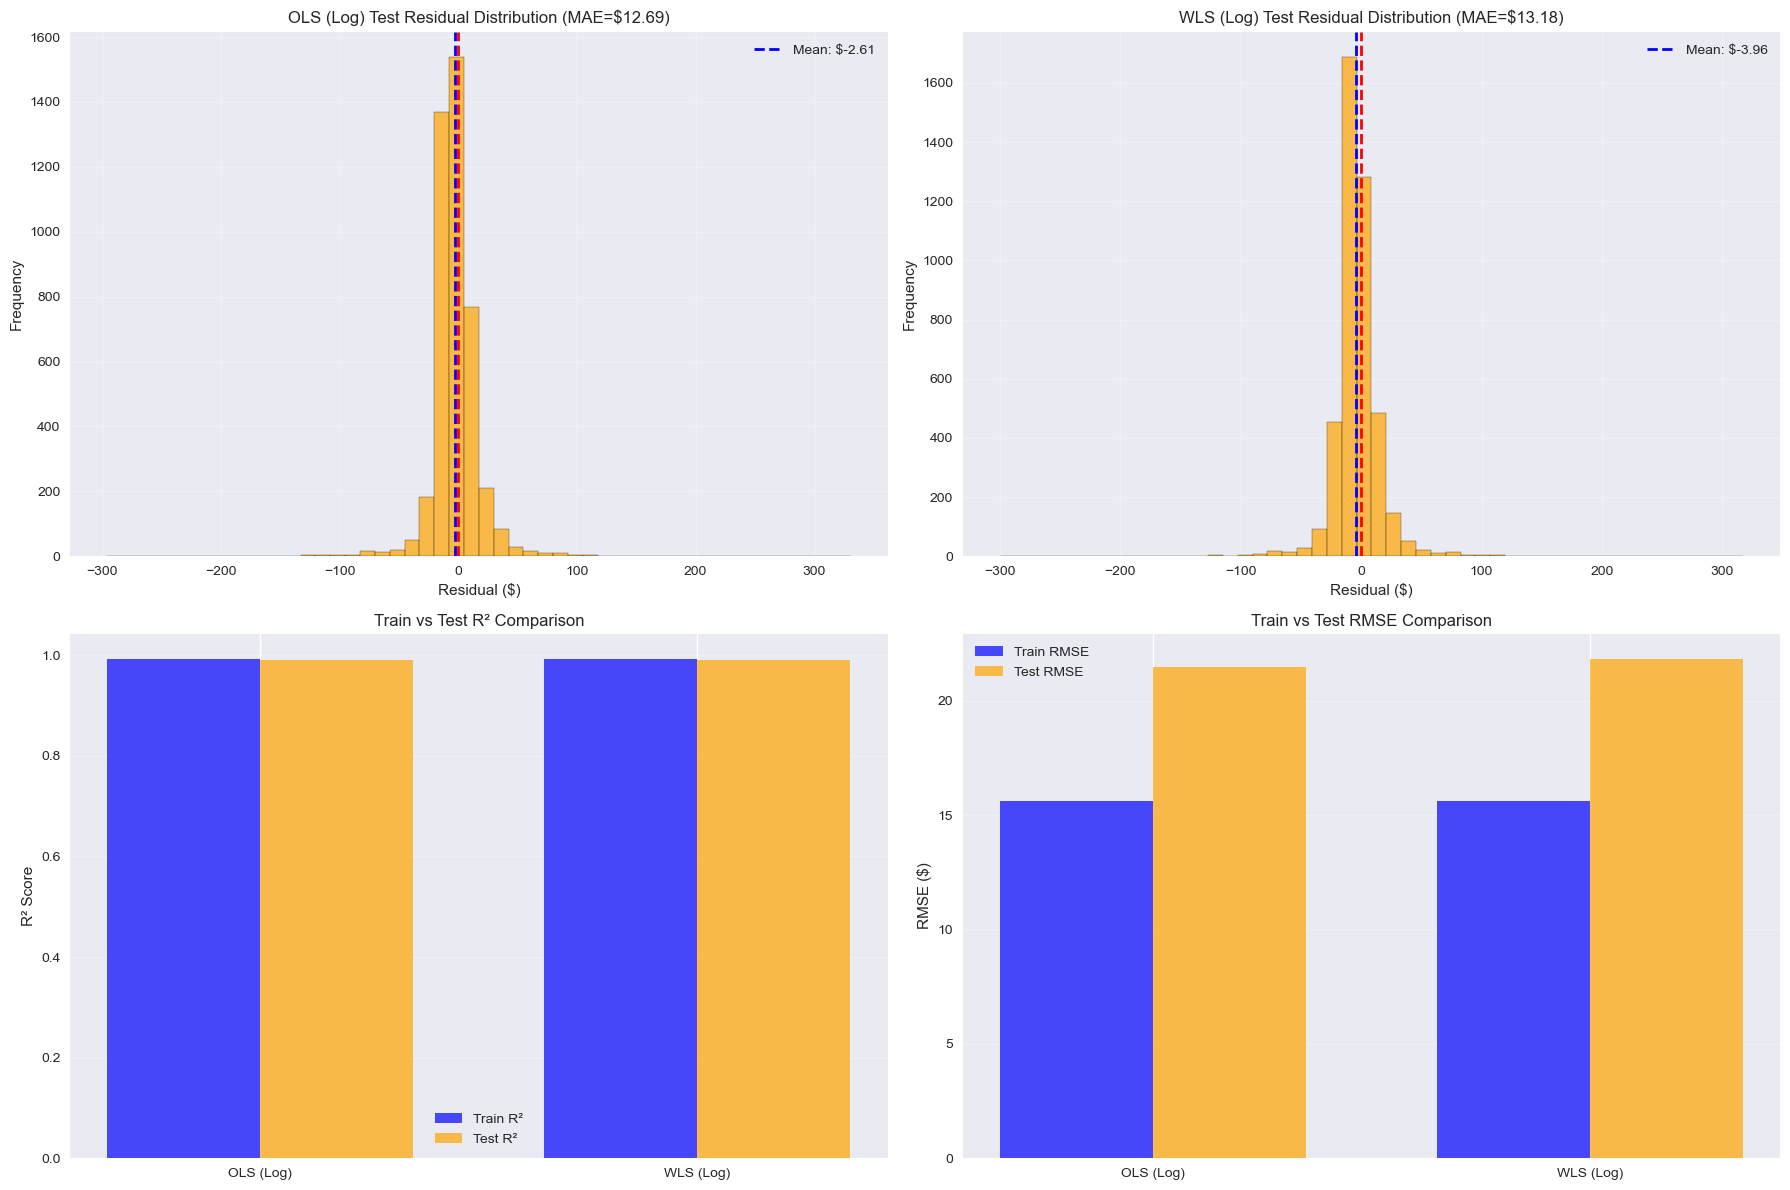

TEST SET PERFORMANCE SUMMARY

OLS (Log) Model:
  Residual Mean: $-2.61
  Residual Std: $21.31
  Median Absolute Error: $9.19
  95th Percentile Error: $34.68

WLS (Log) Model:
  Residual Mean: $-3.96
  Residual Std: $21.46
  Median Absolute Error: $9.64
  95th Percentile Error: $35.53


In [59]:
# Additional Test Set Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Test Error Distribution - OLS
axes[0, 0].hist(ols_log_test_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=ols_log_test_residuals.mean(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Mean: ${ols_log_test_residuals.mean():.2f}')
axes[0, 0].set_xlabel('Residual ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'OLS (Log) Test Residual Distribution (MAE=${ols_log_test_mae:.2f})', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Error Distribution - WLS
axes[0, 1].hist(wls_log_test_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=wls_log_test_residuals.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: ${wls_log_test_residuals.mean():.2f}')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'WLS (Log) Test Residual Distribution (MAE=${wls_log_test_mae:.2f})', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Performance Comparison Bar Chart
models = ['OLS (Log)', 'WLS (Log)']
train_r2s = [ols_log_train_r2, wls_log_train_r2]
test_r2s = [ols_log_test_r2, wls_log_test_r2]

x = np.arange(len(models))
width = 0.35

axes[1, 0].bar(x - width/2, train_r2s, width, label='Train R²', color='blue', alpha=0.7)
axes[1, 0].bar(x + width/2, test_r2s, width, label='Test R²', color='orange', alpha=0.7)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Train vs Test R² Comparison', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: RMSE Comparison
train_rmses = [ols_log_train_rmse, wls_log_train_rmse]
test_rmses = [ols_log_test_rmse, wls_log_test_rmse]

axes[1, 1].bar(x - width/2, train_rmses, width, label='Train RMSE', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, test_rmses, width, label='Test RMSE', color='orange', alpha=0.7)
axes[1, 1].set_ylabel('RMSE ($)')
axes[1, 1].set_title('Train vs Test RMSE Comparison', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics for test set performance
print("=" * 60)
print("TEST SET PERFORMANCE SUMMARY")
print("=" * 60)
print(f"\nOLS (Log) Model:")
print(f"  Residual Mean: ${ols_log_test_residuals.mean():.2f}")
print(f"  Residual Std: ${ols_log_test_residuals.std():.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(ols_log_test_residuals)):.2f}")
print(f"  95th Percentile Error: ${np.percentile(np.abs(ols_log_test_residuals), 95):.2f}")

print(f"\nWLS (Log) Model:")
print(f"  Residual Mean: ${wls_log_test_residuals.mean():.2f}")
print(f"  Residual Std: ${wls_log_test_residuals.std():.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(wls_log_test_residuals)):.2f}")
print(f"  95th Percentile Error: ${np.percentile(np.abs(wls_log_test_residuals), 95):.2f}")
print("=" * 60)


MODEL COEFFICIENTS (Top 20 Features)
                 Feature  OLS Coefficient  WLS Coefficient  OLS P-value  WLS P-value
          log_rent_lag_1         0.951224         0.930326 0.000000e+00 0.000000e+00
          log_rent_lag_2         0.066676         0.052507 4.859747e-19 1.263987e-12
               Intercept         0.062261         0.039437 2.211144e-43 7.335042e-19
          log_rent_lag_4        -0.026269        -0.016335 1.354996e-06 2.571739e-03
property_4 bedroom house         0.016002         0.010560 2.652027e-53 6.066203e-25
 property_3 bedroom flat         0.012311         0.008295 4.237800e-43 4.775088e-21
property_3 bedroom house         0.012267         0.007387 1.140963e-42 5.686758e-17
property_2 bedroom house         0.009103         0.004690 1.117063e-30 1.872306e-09
 property_2 bedroom flat         0.008223         0.005701 5.083918e-29 4.335627e-15
          log_rent_lag_3        -0.007379         0.021107 3.244989e-01 4.390425e-03
          mortgage_rates    

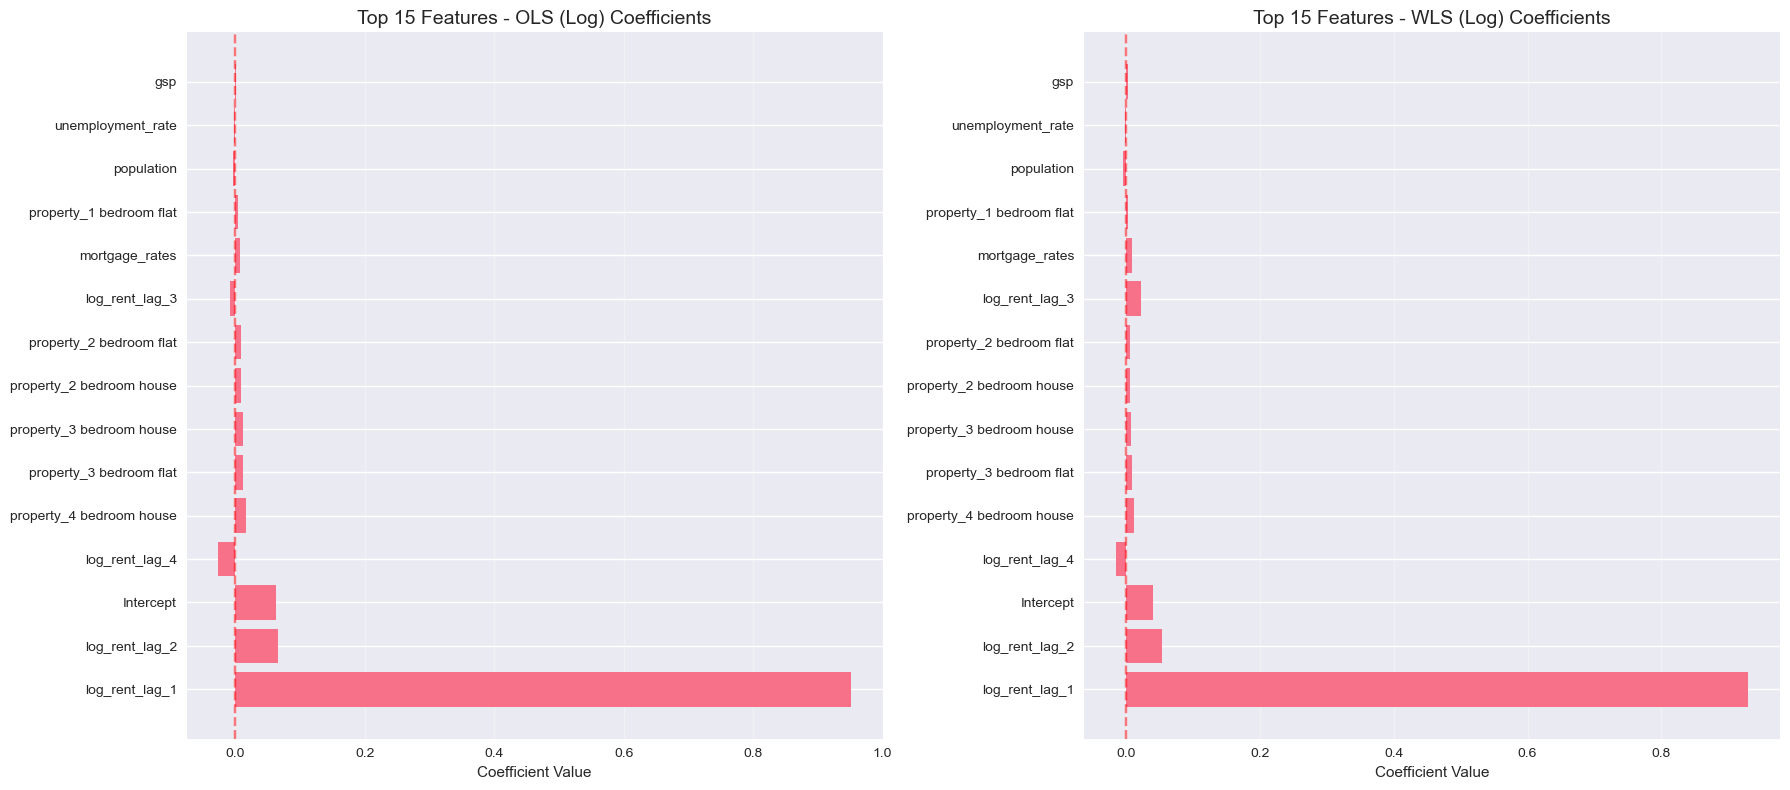

In [60]:
# Feature importance (coefficients) - showing top features
feature_names = ['Intercept'] + all_features
ols_log_coefs = ols_log_model.params
wls_log_coefs = wls_log_model.params

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'OLS Coefficient': ols_log_coefs,
    'WLS Coefficient': wls_log_coefs,
    'OLS P-value': ols_log_model.pvalues,
    'WLS P-value': wls_log_model.pvalues
})

# Sort by absolute OLS coefficient
coef_df['Abs_OLS_Coef'] = np.abs(coef_df['OLS Coefficient'])
coef_df = coef_df.sort_values('Abs_OLS_Coef', ascending=False)

print("=" * 90)
print("MODEL COEFFICIENTS (Top 20 Features)")
print("=" * 90)
print(coef_df[['Feature', 'OLS Coefficient', 'WLS Coefficient', 'OLS P-value', 'WLS P-value']].head(20).to_string(index=False))

# Visualize top coefficients
top_n = min(15, len(coef_df))
top_features = coef_df.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# OLS coefficients
axes[0].barh(range(len(top_features)), top_features['OLS Coefficient'].values)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'].values)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title(f'Top {top_n} Features - OLS (Log) Coefficients', fontsize=14)
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# WLS coefficients
axes[1].barh(range(len(top_features)), top_features['WLS Coefficient'].values)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'].values)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title(f'Top {top_n} Features - WLS (Log) Coefficients', fontsize=14)
axes[1].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 8. Residual Diagnostics on Log Scale


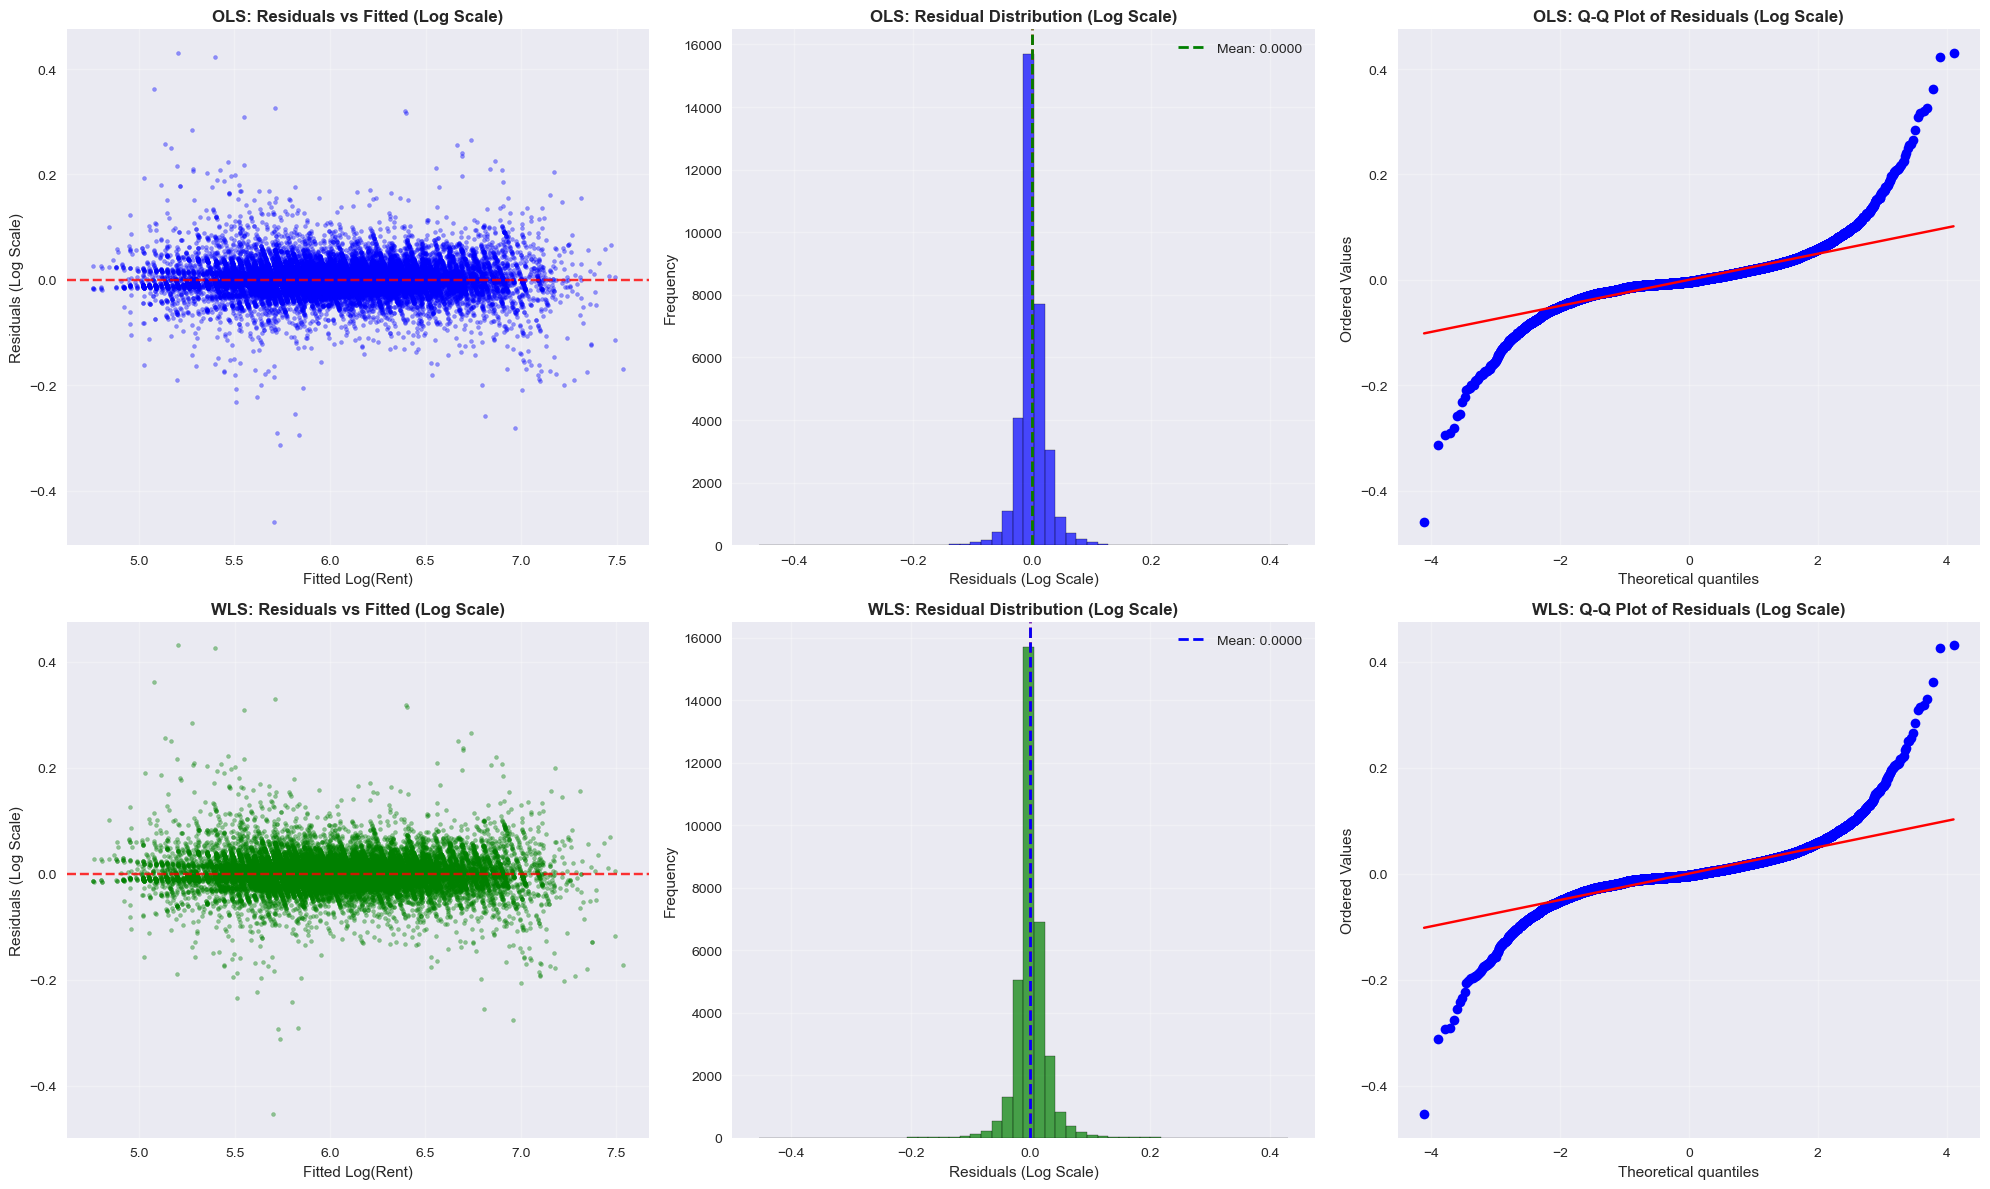

RESIDUAL DIAGNOSTICS (Log Scale)

OLS Residuals (Log Scale):
  Mean: 0.000000
  Std: 0.026973
  Skewness: 0.6293
  Kurtosis: 20.9162

WLS Residuals (Log Scale):
  Mean: 0.000022
  Std: 0.027058
  Skewness: 0.5897
  Kurtosis: 20.3445

✓ Residuals on log scale should be approximately normal


In [62]:
# Analyze residuals on LOG SCALE (before back-transformation)
# This is important to verify normality assumptions
ols_log_train_resid_log = y_train_log - ols_log_train_pred_log
wls_log_train_resid_log = y_train_log - wls_log_train_pred_log

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: OLS Log-Scale Residuals
# Plot 1: Residuals vs Fitted (log scale)
axes[0, 0].scatter(ols_log_train_pred_log, ols_log_train_resid_log, alpha=0.4, s=8, color='blue')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 0].set_xlabel('Fitted Log(Rent)')
axes[0, 0].set_ylabel('Residuals (Log Scale)')
axes[0, 0].set_title('OLS: Residuals vs Fitted (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram of residuals (log scale)
axes[0, 1].hist(ols_log_train_resid_log, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=ols_log_train_resid_log.mean(), color='green', linestyle='--', linewidth=2,
                   label=f'Mean: {ols_log_train_resid_log.mean():.4f}')
axes[0, 1].set_xlabel('Residuals (Log Scale)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('OLS: Residual Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Q-Q plot of residuals (log scale)
stats.probplot(ols_log_train_resid_log, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('OLS: Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: WLS Log-Scale Residuals
# Plot 4: Residuals vs Fitted (log scale)
axes[1, 0].scatter(wls_log_train_pred_log, wls_log_train_resid_log, alpha=0.4, s=8, color='green')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 0].set_xlabel('Fitted Log(Rent)')
axes[1, 0].set_ylabel('Residuals (Log Scale)')
axes[1, 0].set_title('WLS: Residuals vs Fitted (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Histogram of residuals (log scale)
axes[1, 1].hist(wls_log_train_resid_log, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=wls_log_train_resid_log.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {wls_log_train_resid_log.mean():.4f}')
axes[1, 1].set_xlabel('Residuals (Log Scale)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('WLS: Residual Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Q-Q plot of residuals (log scale)
stats.probplot(wls_log_train_resid_log, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('WLS: Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("RESIDUAL DIAGNOSTICS (Log Scale)")
print("=" * 70)
print(f"\nOLS Residuals (Log Scale):")
print(f"  Mean: {ols_log_train_resid_log.mean():.6f}")
print(f"  Std: {ols_log_train_resid_log.std():.6f}")
print(f"  Skewness: {stats.skew(ols_log_train_resid_log):.4f}")
print(f"  Kurtosis: {stats.kurtosis(ols_log_train_resid_log):.4f}")

print(f"\nWLS Residuals (Log Scale):")
print(f"  Mean: {wls_log_train_resid_log.mean():.6f}")
print(f"  Std: {wls_log_train_resid_log.std():.6f}")
print(f"  Skewness: {stats.skew(wls_log_train_resid_log):.4f}")
print(f"  Kurtosis: {stats.kurtosis(wls_log_train_resid_log):.4f}")

print("\n✓ Residuals on log scale should be approximately normal")
print("=" * 70)


# 10 Forecasting

In [65]:
# Define and load datasets necessary for forecasting
df_forecast = df_clean.copy()

# open the economic forecast csv
economic_forecast = pd.read_csv('../data/curated/rent_growth/economic_forecast.csv')

# Extract the economic features that the WLS model was trained on
economic_features = ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population']
economic_forecast = economic_forecast[economic_features]

# Load spatial connectivity matrix
# To use for updating spatial lags
W_df = pd.read_csv('../data/curated/rent_growth/weight_matrix.csv', index_col=0)

print(f"Spatial connectivity matrix shape: {W_df.shape}")

Spatial connectivity matrix shape: (143, 143)


In [66]:
# =============================================================================
# CREATE SPATIAL MAPPINGS FROM EXISTING DATA
# =============================================================================

# Convert to numpy array
W_matrix = W_df.values

# Create suburb to index mapping from the matrix index
suburb_to_idx = {suburb: idx for idx, suburb in enumerate(W_df.index)}
suburbs_in_matrix = list(W_df.index)

print(f"  - suburb_to_idx: {len(suburb_to_idx)} suburbs")
print(f"  - suburbs_in_matrix: {len(suburbs_in_matrix)} suburbs")
print(f"  - W_matrix shape: {W_matrix.shape}")




  - suburb_to_idx: 143 suburbs
  - suburbs_in_matrix: 143 suburbs
  - W_matrix shape: (143, 143)


In [67]:
# =============================================================================
# SPATIAL LAG FUNCTIONS FOR FORECAST ITERATIONS
# =============================================================================

def calculate_spatial_lag_for_forecast(suburb, property_type, quarter_predictions, W_matrix, suburb_to_idx):
    """
    Calculate spatial lag for a single suburb/property type at a single time step during forecasting.
    """
    
    # Check if suburb exists in spatial matrix
    if suburb not in suburb_to_idx:
        return 0.0
    
    suburb_idx = suburb_to_idx[suburb]
    spatial_lag = 0.0
    
    # Calculate weighted average of neighbor predictions
    for neighbor_idx, weight in enumerate(W_matrix[suburb_idx, :]):
        if weight > 0:  
            # Get neighbor suburb name
            neighbor_suburb = list(suburb_to_idx.keys())[neighbor_idx]
            
            # Find prediction for this neighbor with same property type
            neighbor_key = (neighbor_suburb, property_type)
            if neighbor_key in quarter_predictions:
                neighbor_rent = quarter_predictions[neighbor_key]
                spatial_lag += weight * neighbor_rent
            else:
                # If no prediction available use 0 
                spatial_lag += weight * 0.0
    
    return spatial_lag


def calculate_spatial_lag_alternative(suburb, property_type, quarter_predictions, W_matrix, suburb_to_idx):
    """
    Alternative spatial lag calculation that averages across all property types for neighbors.
    This matches the training approach where spatial lags are calculated across all property types.
    """
    
    if suburb not in suburb_to_idx:
        return 0.0
    
    suburb_idx = suburb_to_idx[suburb]
    spatial_lag = 0.0
    
    # Calculate weighted average of neighbor predictions
    for neighbor_idx, weight in enumerate(W_matrix[suburb_idx, :]):
        if weight > 0:  # If there's a spatial connection
            neighbor_suburb = list(suburb_to_idx.keys())[neighbor_idx]
            
            # Get all property type predictions for this neighbor
            neighbor_rents = []
            for prop_type in ['1 bedroom flat', '2 bedroom flat', '2 bedroom house', 
                            '3 bedroom flat', '3 bedroom house', '4 bedroom house']:
                neighbor_key = (neighbor_suburb, prop_type)
                if neighbor_key in quarter_predictions:
                    neighbor_rents.append(quarter_predictions[neighbor_key])
            
            # Average across all property types same method as in training
            if neighbor_rents:
                neighbor_avg_rent = np.mean(neighbor_rents)
                spatial_lag += weight * neighbor_avg_rent
    
    return spatial_lag


def update_spatial_lags_for_quarter(quarter_predictions, W_matrix, suburb_to_idx, method='alternative'):
    """
    Update spatial lags for all suburb/property type combinations for a single quarter.
    """
    
    updated_spatial_lags = {}
    
    for (suburb, property_type), predicted_rent in quarter_predictions.items():
        if method == 'exact':
            spatial_lag = calculate_spatial_lag_for_forecast(
                suburb, property_type, quarter_predictions, W_matrix, suburb_to_idx
            )
        else:  # alternative method
            spatial_lag = calculate_spatial_lag_alternative(
                suburb, property_type, quarter_predictions, W_matrix, suburb_to_idx
            )
        
        updated_spatial_lags[(suburb, property_type)] = spatial_lag
    
    return updated_spatial_lags

In [68]:
# =============================================================================
# FORECAST FUNCTION WITH SPATIAL LAG UPDATES
# =============================================================================

def create_spatial_forecast(df_clean, wls_log_model, economic_forecast, W_matrix, suburb_to_idx, forecast_quarters=20):
    """
    Forecast function with spatial lag updates.
    
    Key Fixes:
    1. Quarter-first processing
    2. Calculate ALL spatial lags for a quarter BEFORE making predictions
    3. Safe log transformation for spatial lags
    4. Consistent neighbor data across all suburbs for each quarter
    """
    
    print(f"Creating CORRECTED dynamic spatial forecast for {forecast_quarters} quarters...")
    
    # Get base information
    base_date = df_clean['date'].max()
    suburbs = sorted(df_clean['suburb'].unique())
    property_types = sorted(df_clean['property_type'].unique())
    
    # Create forecast dates
    forecast_dates = pd.date_range(start=base_date, periods=forecast_quarters+1, freq='Q')[1:]
    
    print(f"Base date: {base_date.date()}")
    print(f"Forecast dates: {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
    
    # Economic features
    economic_features = ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population']
    
    # Initialise forecast storage
    all_forecasts = []
    
    # Initialise lagged values and historical data for all valid combinations
    lagged_values = {}
    historical_spatial_lags = {}  
    historical_median_income = {}  
    valid_combinations = []
    
    for suburb in suburbs:
        for property_type in property_types:
            unit_data = df_clean[
                (df_clean['suburb'] == suburb) & 
                (df_clean['property_type'] == property_type)
            ].sort_values('date')
            
            if len(unit_data) < 4:
                print(f"  Skipping {suburb} - {property_type}: insufficient data ({len(unit_data)} obs)")
                continue
            
            # Store initial lagged values
            recent_rents = unit_data['median_rent'].tail(4).values
            lagged_values[(suburb, property_type)] = np.log(recent_rents)
            
            # Store historical spatial lag
            historical_spatial_lag = unit_data['spatial_lag'].iloc[-1] if 'spatial_lag' in unit_data.columns else 0
            historical_spatial_lags[(suburb, property_type)] = historical_spatial_lag
            
            # Store historical median personal income
            historical_income = unit_data['median_personal_income'].iloc[-1] if 'median_personal_income' in unit_data.columns else economic_forecast['median_personal_income'].iloc[0]
            historical_median_income[(suburb, property_type)] = historical_income
            
            valid_combinations.append((suburb, property_type))
    
    print(f"\nProcessing {len(valid_combinations)} valid spatial unit/property type combinations...")
    
    # Global storage for predictions
    quarter_predictions = {}
    
    # QUARTER-FIRST LOOP 
    for quarter_idx, forecast_date in enumerate(forecast_dates):
        print(f"  Processing quarter {quarter_idx + 1}/{len(forecast_dates)}: {forecast_date.date()}")
        
        # STEP 1: Calculate spatial lags for all combinations for this quarter
        spatial_lags = {}
        
        for suburb, property_type in valid_combinations:
            if quarter_idx == 0:
                # For first quarter, use historical spatial lag 
                spatial_lag = historical_spatial_lags[(suburb, property_type)]
            else:
                # For subsequent quarters, use updated spatial lag from previous quarter prediction
                spatial_lag = calculate_spatial_lag_alternative(
                    suburb, property_type, quarter_predictions, W_matrix, suburb_to_idx
                )
            
            # Safe log transformation prevents log(0)
            spatial_lag = max(spatial_lag, 1e-10) 
            spatial_lags[(suburb, property_type)] = np.log(spatial_lag)
        
        # STEP 2: Make predictions for all combinations for this quarter
        for suburb, property_type in valid_combinations:
            # Get economic features for this quarter
            quarter_economic = economic_forecast.iloc[quarter_idx]
            
            # Get lagged values and spatial lag
            log_rent_lags = lagged_values[(suburb, property_type)]
            log_spatial_lag = spatial_lags[(suburb, property_type)]
            
            # Create feature vector in the same order as model training
            feature_vector = np.array([
                log_rent_lags[0],  
                log_rent_lags[1],  
                log_rent_lags[2], 
                log_rent_lags[3],  
                log_spatial_lag,   
                quarter_economic['cpi'],
                quarter_economic['unemployment_rate'],
                quarter_economic['mortgage_rates'],
                quarter_economic['gsp'],
                quarter_economic['population'],
                historical_median_income[(suburb, property_type)],
                # Property type dummies
                1 if property_type == '1 bedroom flat' else 0,
                1 if property_type == '2 bedroom flat' else 0,
                1 if property_type == '2 bedroom house' else 0,
                1 if property_type == '3 bedroom flat' else 0,
                1 if property_type == '3 bedroom house' else 0,
                1 if property_type == '4 bedroom house' else 0,
            ])
            
            # Make prediction
            X_pred = feature_vector.reshape(1, -1)
            X_pred_const = sm.add_constant(X_pred, has_constant='add')
            
            log_pred = wls_log_model.predict(X_pred_const)[0]
            pred_original = np.exp(log_pred)
            
            # Store prediction for next quarter's spatial lag calculation
            quarter_predictions[(suburb, property_type)] = pred_original
            
            # Update lagged values for next quarter
            lagged_values[(suburb, property_type)] = np.roll(log_rent_lags, -1)
            lagged_values[(suburb, property_type)][-1] = log_pred
            
            # Store forecast
            all_forecasts.append({
                'suburb': suburb,
                'property_type': property_type,
                'date': forecast_date,
                'prediction': pred_original,
                'log_prediction': log_pred,
                'spatial_lag': np.exp(log_spatial_lag),
                'log_spatial_lag': log_spatial_lag,
                'quarter': quarter_idx + 1,
            })
    
    print(f"\n{'='*80}")
    print("CORRECTED DYNAMIC SPATIAL FORECAST COMPLETED")
    print(f"{'='*80}")
    print(f"Total forecasts generated: {len(all_forecasts):,}")
    print(f"Date range: {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
    print(f"Prediction range: ${min([f['prediction'] for f in all_forecasts]):.2f} - ${max([f['prediction'] for f in all_forecasts]):.2f}")
    print(f"Suburbs: {len(set([f['suburb'] for f in all_forecasts])):,}")
    print(f"Property types: {len(set([f['property_type'] for f in all_forecasts])):,}")
    print(f"{'='*80}")
    
    return pd.DataFrame(all_forecasts)

print("✓ Forecast function defined")


✓ Forecast function defined


In [69]:
# Forecast for entire dataset
forecast_results =  create_spatial_forecast(
        df_forecast, wls_log_model, economic_forecast, W_matrix, suburb_to_idx, forecast_quarters=20
    )

Creating CORRECTED dynamic spatial forecast for 20 quarters...
Base date: 2025-03-01
Forecast dates: 2025-06-30 to 2030-03-31
  Skipping castlemaine - 1 bedroom flat: insufficient data (1 obs)
  Skipping castlemaine - 3 bedroom flat: insufficient data (0 obs)
  Skipping docklands - 3 bedroom house: insufficient data (0 obs)
  Skipping docklands - 4 bedroom house: insufficient data (0 obs)
  Skipping hamilton - 3 bedroom flat: insufficient data (0 obs)
  Skipping keilor - 1 bedroom flat: insufficient data (0 obs)
  Skipping keilor - 2 bedroom flat: insufficient data (0 obs)
  Skipping keilor - 2 bedroom house: insufficient data (0 obs)
  Skipping rowville - 2 bedroom house: insufficient data (0 obs)
  Skipping seymour - 3 bedroom flat: insufficient data (0 obs)
  Skipping southbank - 2 bedroom house: insufficient data (0 obs)
  Skipping southbank - 3 bedroom house: insufficient data (0 obs)
  Skipping southbank - 4 bedroom house: insufficient data (0 obs)

Processing 845 valid spatial u

In [71]:
# =============================================================================
# ANALYSIS OF FORECAST RESULTS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

print("=" * 80)
print("ANALYSIS OF FORECAST RESULTS")
print("=" * 80)


if len(forecast_results) > 0:
    
    # 1. DESCRIPTIVE STATISTICS
    print("DESCRIPTIVE STATISTICS")
    print("-" * 50)
    
    n_forecasts = len(forecast_results)
    n_suburbs = forecast_results['suburb'].nunique() if 'suburb' in forecast_results.columns else forecast_results['spatial_unit'].nunique()
    n_property_types = forecast_results['property_type'].nunique()
    
    print(f"Sample Size:")
    print(f"  Total forecasts: {n_forecasts:,}")
    print(f"  Suburbs: {n_suburbs:,}")
    print(f"  Property types: {n_property_types:,}")
    
    # Prediction statistics
    pred_stats = forecast_results['prediction'].describe()
    print(f"\nPrediction Statistics:")
    print(f"  Mean: ${pred_stats['mean']:,.2f}")
    print(f"  Median: ${pred_stats['50%']:,.2f}")
    print(f"  Std Dev: ${pred_stats['std']:,.2f}")
    print(f"  Min: ${pred_stats['min']:,.2f}")
    print(f"  Max: ${pred_stats['max']:,.2f}")
    print(f"  Range: ${pred_stats['max'] - pred_stats['min']:,.2f}")
    
    # 2. STATISTICAL TESTS
    print(f"\n STATISTICAL TESTS")
    print("-" * 50)
    
    # Normality test
    sample_size = min(5000, len(forecast_results))
    shapiro_stat, shapiro_p = stats.shapiro(forecast_results['prediction'].sample(sample_size))
    print(f"Normality Test (Shapiro-Wilk):")
    print(f"  Statistic: {shapiro_stat:.4f}")
    print(f"  p-value: {shapiro_p:.2e}")
    print(f"  Normal distribution: {'Yes' if shapiro_p > 0.05 else 'No'}")
    
    # Log-normality test
    log_shapiro_stat, log_shapiro_p = stats.shapiro(forecast_results['log_prediction'].sample(sample_size))
    print(f"\nLog-Normality Test:")
    print(f"  Statistic: {log_shapiro_stat:.4f}")
    print(f"  p-value: {log_shapiro_p:.2e}")
    print(f"  Log-normal distribution: {'Yes' if log_shapiro_p > 0.05 else 'No'}")
    
    # 3. PROPERTY TYPE ANALYSIS
    print(f"\n PROPERTY TYPE STATISTICAL ANALYSIS")
    print("-" * 50)
    
    prop_stats = forecast_results.groupby('property_type')['prediction'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    print("Property Type Statistics:")
    for prop_type, stats_row in prop_stats.iterrows():
        print(f"\n  {prop_type}:")
        print(f"    Count: {stats_row['count']:,}")
        print(f"    Mean: ${stats_row['mean']:,.2f}")
        print(f"    Median: ${stats_row['median']:,.2f}")
        print(f"    Std Dev: ${stats_row['std']:,.2f}")
    
    # ANOVA test for property type differences
    property_groups = [group['prediction'].values for name, group in forecast_results.groupby('property_type')]
    f_stat, f_p = stats.f_oneway(*property_groups)
    print(f"\nProperty Type Differences (ANOVA):")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {f_p:.2e}")
    print(f"  Significant differences: {'Yes' if f_p < 0.05 else 'No'}")


ANALYSIS OF FORECAST RESULTS
DESCRIPTIVE STATISTICS
--------------------------------------------------
Sample Size:
  Total forecasts: 16,900
  Suburbs: 143
  Property types: 6

Prediction Statistics:
  Mean: $606.57
  Median: $557.23
  Std Dev: $232.75
  Min: $175.96
  Max: $1,982.38
  Range: $1,806.42

 STATISTICAL TESTS
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Statistic: 0.8949
  p-value: 4.81e-50
  Normal distribution: No

Log-Normality Test:
  Statistic: 0.9902
  p-value: 4.19e-18
  Log-normal distribution: No

 PROPERTY TYPE STATISTICAL ANALYSIS
--------------------------------------------------
Property Type Statistics:

  1 bedroom flat:
    Count: 2,820.0
    Mean: $397.01
    Median: $405.01
    Std Dev: $85.76

  2 bedroom flat:
    Count: 2,840.0
    Mean: $516.69
    Median: $516.50
    Std Dev: $108.11

  2 bedroom house:
    Count: 2,800.0
    Mean: $549.27
    Median: $521.44
    Std Dev: $130.43

  3 bedroom flat:
    Count: 2

# 11 Growth Rate Calculation

In [73]:
# Filter out the final forecast quarter to use for growth rate calculation
final_forecasts = forecast_results[forecast_results['quarter'] == 20]

In [74]:
# =============================================================================
# TOP 10 RENT GROWTH COMBINATIONS - DETAILED VIEW
# =============================================================================

print("TOP 10 RENT GROWTH COMBINATIONS")
print("=" * 60)

# Calculate rent growth for all combinations
rent_growth_data = []

for _, row in final_forecasts.iterrows():
    suburb = row['suburb']
    property_type = row['property_type']
    
    # Get historical data for this combination
    combo_data = df_clean[(df_clean['suburb'] == suburb) & 
                         (df_clean['property_type'] == property_type)].copy()
    
    if len(combo_data) >= 2:
        # Get baseline rent (latest historical)
        baseline_rent = combo_data['median_rent'].iloc[-1]
        
        # Get forecast rent (Q4 2025)
        forecast_rent = row['prediction']
        # Calculate growth
        absolute_growth = forecast_rent - baseline_rent
        percentage_growth = (absolute_growth / baseline_rent) * 100
        annualized_growth = percentage_growth / 5  # 5-year forecast
        
        rent_growth_data.append({
            'suburb': suburb,
            'property_type': property_type,
            'baseline_rent': baseline_rent,
            'forecast_rent': forecast_rent,
            'absolute_growth': absolute_growth,
            'percentage_growth': percentage_growth,
            'annualized_growth': annualized_growth
        })

# Convert to DataFrame and sort by percentage growth
rent_growth_df = pd.DataFrame(rent_growth_data)
rent_growth_df = rent_growth_df.sort_values('percentage_growth', ascending=False)

# Show top 10
top_10 = rent_growth_df.head(10)

print("\nTOP 10 RENT GROWTH COMBINATIONS:")
print("-" * 60)

for i, (_, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i:2d}. {row['suburb']} - {row['property_type']}")
    print(f"    Baseline Rent: ${row['baseline_rent']:,.0f}")
    print(f"    Forecast Rent: ${row['forecast_rent']:,.0f}")
    print(f"    Growth: ${row['absolute_growth']:,.0f} ({row['percentage_growth']:+.1f}%)")
    print(f"    Annualized: {row['annualized_growth']:+.1f}% per year")
    print()

# Summary statistics for top 10
print("TOP 10 SUMMARY STATISTICS:")
print("-" * 60)
print(f"Average Growth: {top_10['percentage_growth'].mean():.1f}%")
print(f"Median Growth: {top_10['percentage_growth'].median():.1f}%")
print(f"Max Growth: {top_10['percentage_growth'].max():.1f}%")
print(f"Min Growth: {top_10['percentage_growth'].min():.1f}%")
print(f"Average Annualized: {top_10['annualized_growth'].mean():.1f}% per year")
print()

# Property type breakdown for top 10
print("PROPERTY TYPE BREAKDOWN (Top 10):")
print("-" * 60)
property_breakdown = top_10['property_type'].value_counts()
for prop_type, count in property_breakdown.items():
    print(f"{prop_type}: {count} combinations")


TOP 10 RENT GROWTH COMBINATIONS

TOP 10 RENT GROWTH COMBINATIONS:
------------------------------------------------------------
 1. mount waverley - 1 bedroom flat
    Baseline Rent: $262
    Forecast Rent: $314
    Growth: $52 (+19.9%)
    Annualized: +4.0% per year

 2. horsham - 1 bedroom flat
    Baseline Rent: $300
    Forecast Rent: $347
    Growth: $47 (+15.5%)
    Annualized: +3.1% per year

 3. mount clear-buninyong - 1 bedroom flat
    Baseline Rent: $170
    Forecast Rent: $192
    Growth: $22 (+13.1%)
    Annualized: +2.6% per year

 4. brighton east - 1 bedroom flat
    Baseline Rent: $265
    Forecast Rent: $297
    Growth: $32 (+12.1%)
    Annualized: +2.4% per year

 5. warragul - 1 bedroom flat
    Baseline Rent: $251
    Forecast Rent: $278
    Growth: $27 (+10.8%)
    Annualized: +2.2% per year

 6. lara - 1 bedroom flat
    Baseline Rent: $200
    Forecast Rent: $221
    Growth: $21 (+10.7%)
    Annualized: +2.1% per year

 7. williamstown - 3 bedroom flat
    Baseli

GROWTH RATE VISUALISATION ANALYSIS


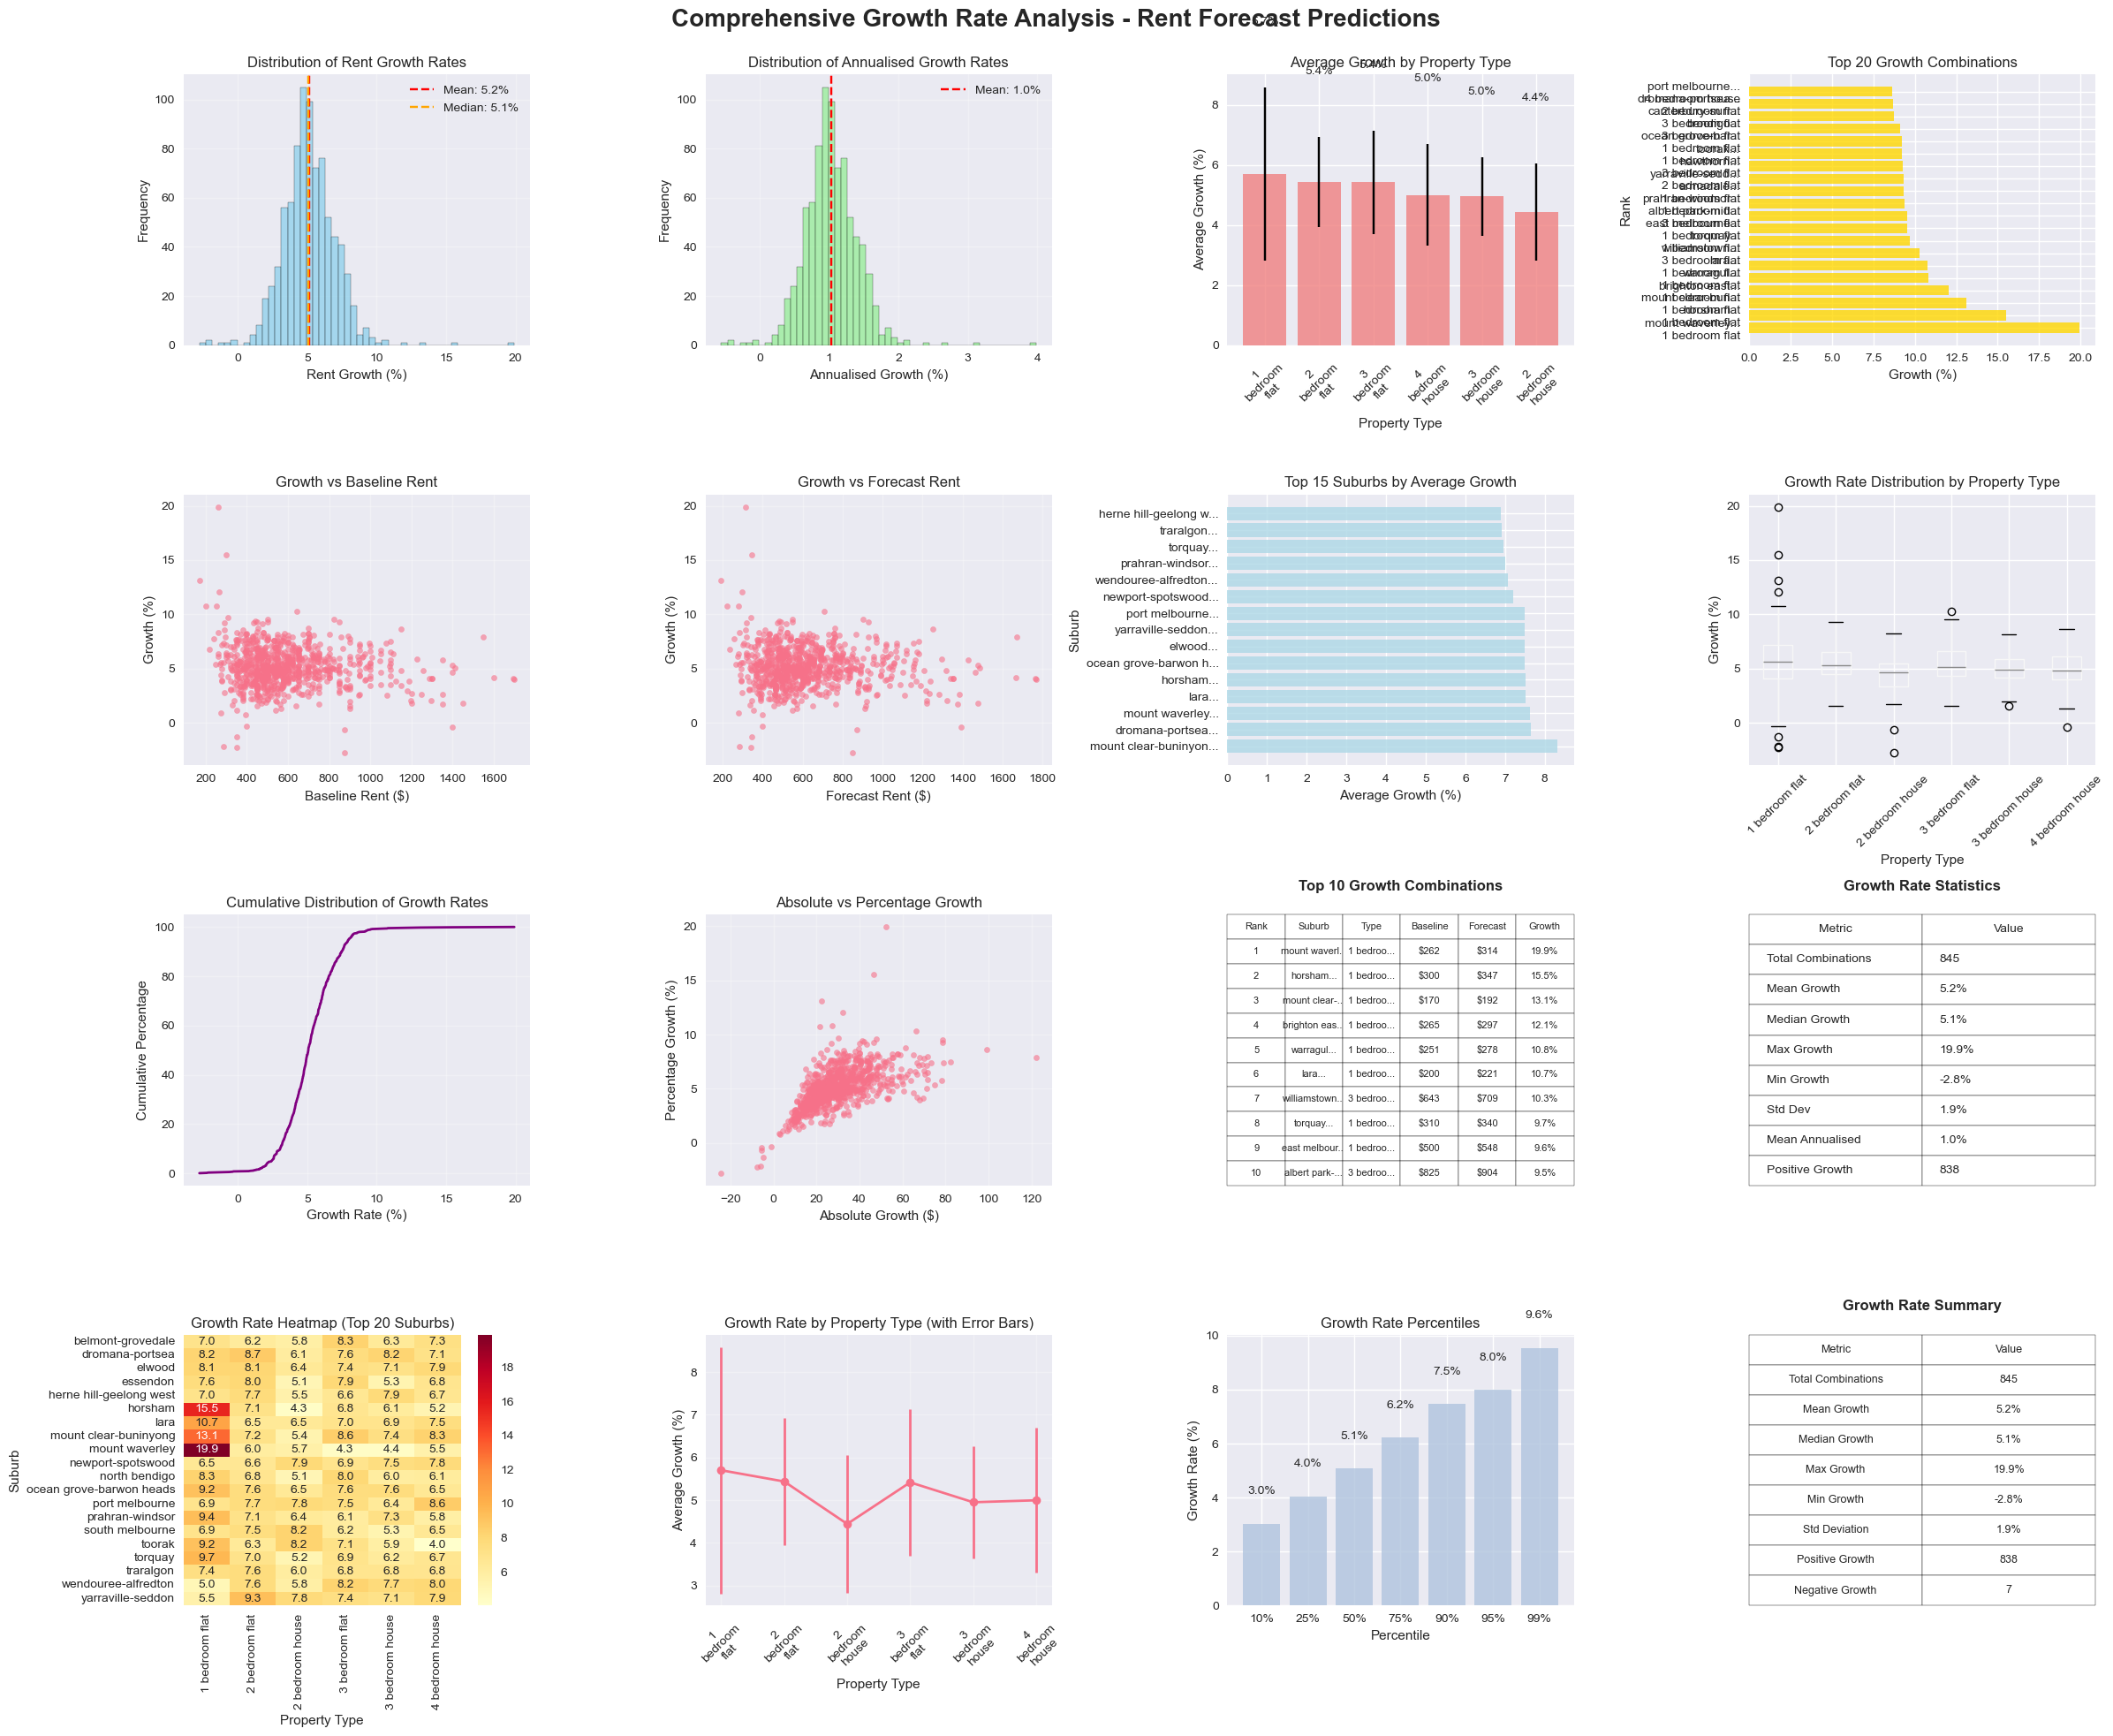

In [75]:
# =============================================================================
# GROWTH RATE VISUALISATIONS - COMPREHENSIVE ANALYSIS
# =============================================================================

print("GROWTH RATE VISUALISATION ANALYSIS")
print("=" * 80)

# Create comprehensive growth rate visualisations
fig = plt.figure(figsize=(24, 20))

# 1. Growth Rate Distribution
plt.subplot(4, 4, 1)
plt.hist(rent_growth_df['percentage_growth'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(rent_growth_df['percentage_growth'].mean(), color='red', linestyle='--', 
            label=f'Mean: {rent_growth_df["percentage_growth"].mean():.1f}%')
plt.axvline(rent_growth_df['percentage_growth'].median(), color='orange', linestyle='--', 
            label=f'Median: {rent_growth_df["percentage_growth"].median():.1f}%')
plt.xlabel('Rent Growth (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Rent Growth Rates')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Annualised Growth Distribution
plt.subplot(4, 4, 2)
plt.hist(rent_growth_df['annualized_growth'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(rent_growth_df['annualized_growth'].mean(), color='red', linestyle='--', 
            label=f'Mean: {rent_growth_df["annualized_growth"].mean():.1f}%')
plt.xlabel('Annualised Growth (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Annualised Growth Rates')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Growth by Property Type
plt.subplot(4, 4, 3)
prop_growth = rent_growth_df.groupby('property_type')['percentage_growth'].agg(['mean', 'median', 'std']).sort_values('mean', ascending=False)
x_pos = range(len(prop_growth))
plt.bar(x_pos, prop_growth['mean'], yerr=prop_growth['std'], capsize=5, alpha=0.8, color='lightcoral')
plt.xlabel('Property Type')
plt.ylabel('Average Growth (%)')
plt.title('Average Growth by Property Type')
plt.xticks(x_pos, [pt.replace(' ', '\n') for pt in prop_growth.index], rotation=45)
for i, (mean_val, std_val) in enumerate(zip(prop_growth['mean'], prop_growth['std'])):
    plt.text(i, mean_val + std_val + 2, f'{mean_val:.1f}%', ha='center', va='bottom')

# 4. Top 20 Growth Combinations
plt.subplot(4, 4, 4)
top_20 = rent_growth_df.head(20)
plt.barh(range(len(top_20)), top_20['percentage_growth'], color='gold', alpha=0.8)
plt.xlabel('Growth (%)')
plt.ylabel('Rank')
plt.title('Top 20 Growth Combinations')
plt.yticks(range(len(top_20)), [f"{row['suburb'][:15]}...\n{row['property_type']}" for _, row in top_20.iterrows()])

# 5. Growth vs Baseline Rent
plt.subplot(4, 4, 5)
sample_data = rent_growth_df.sample(min(2000, len(rent_growth_df)))
plt.scatter(sample_data['baseline_rent'], sample_data['percentage_growth'], alpha=0.6, s=20)
plt.xlabel('Baseline Rent ($)')
plt.ylabel('Growth (%)')
plt.title('Growth vs Baseline Rent')
plt.grid(True, alpha=0.3)

# 6. Growth vs Forecast Rent
plt.subplot(4, 4, 6)
plt.scatter(sample_data['forecast_rent'], sample_data['percentage_growth'], alpha=0.6, s=20)
plt.xlabel('Forecast Rent ($)')
plt.ylabel('Growth (%)')
plt.title('Growth vs Forecast Rent')
plt.grid(True, alpha=0.3)

# 7. Top Suburbs by Average Growth
plt.subplot(4, 4, 7)
suburb_growth = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(15)
plt.barh(range(len(suburb_growth)), suburb_growth.values, color='lightblue', alpha=0.8)
plt.xlabel('Average Growth (%)')
plt.ylabel('Suburb')
plt.title('Top 15 Suburbs by Average Growth')
plt.yticks(range(len(suburb_growth)), [sub.replace('_', ' ')[:20] + '...' for sub in suburb_growth.index])

# 8. Growth Rate Box Plot by Property Type
plt.subplot(4, 4, 8)
rent_growth_df.boxplot(column='percentage_growth', by='property_type', ax=plt.gca())
plt.title('Growth Rate Distribution by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Growth (%)')
plt.xticks(rotation=45)

# 9. Cumulative Growth Distribution
plt.subplot(4, 4, 9)
sorted_growth = np.sort(rent_growth_df['percentage_growth'])
cumulative_pct = np.arange(1, len(sorted_growth) + 1) / len(sorted_growth) * 100
plt.plot(sorted_growth, cumulative_pct, linewidth=2, color='purple')
plt.xlabel('Growth Rate (%)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Growth Rates')
plt.grid(True, alpha=0.3)

# 10. Growth Rate vs Absolute Growth
plt.subplot(4, 4, 10)
plt.scatter(rent_growth_df['absolute_growth'], rent_growth_df['percentage_growth'], alpha=0.6, s=20)
plt.xlabel('Absolute Growth ($)')
plt.ylabel('Percentage Growth (%)')
plt.title('Absolute vs Percentage Growth')
plt.grid(True, alpha=0.3)

# 11. Top 10 Detailed Table
plt.subplot(4, 4, 11)
plt.axis('off')
top_10_data = []
for i, (_, row) in enumerate(top_10.iterrows(), 1):
    top_10_data.append([
        f"{i}",
        f"{row['suburb'][:12]}...",
        f"{row['property_type'][:8]}...",
        f"${row['baseline_rent']:.0f}",
        f"${row['forecast_rent']:.0f}",
        f"{row['percentage_growth']:.1f}%"
    ])

table = plt.table(cellText=top_10_data, 
                 colLabels=['Rank', 'Suburb', 'Type', 'Baseline', 'Forecast', 'Growth'],
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
plt.title('Top 10 Growth Combinations', fontsize=12, fontweight='bold', pad=20)

# 12. Growth Rate Statistics
plt.subplot(4, 4, 12)
plt.axis('off')
growth_stats = {
    'Total Combinations': f"{len(rent_growth_df):,}",
    'Mean Growth': f"{rent_growth_df['percentage_growth'].mean():.1f}%",
    'Median Growth': f"{rent_growth_df['percentage_growth'].median():.1f}%",
    'Max Growth': f"{rent_growth_df['percentage_growth'].max():.1f}%",
    'Min Growth': f"{rent_growth_df['percentage_growth'].min():.1f}%",
    'Std Dev': f"{rent_growth_df['percentage_growth'].std():.1f}%",
    'Mean Annualised': f"{rent_growth_df['annualized_growth'].mean():.1f}%",
    'Positive Growth': f"{(rent_growth_df['percentage_growth'] > 0).sum():,}"
}
stats_data = [[k, v] for k, v in growth_stats.items()]
stats_table = plt.table(cellText=stats_data, colLabels=['Metric', 'Value'], 
                       cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
stats_table.auto_set_font_size(False)
stats_table.set_fontsize(10)
stats_table.scale(1, 1.5)
plt.title('Growth Rate Statistics', fontsize=12, fontweight='bold', pad=20)

# 13. Growth Rate Heatmap by Property Type and Suburb
plt.subplot(4, 4, 13)
# Sample top 20 suburbs for heatmap
top_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(20).index
heatmap_data = rent_growth_df[rent_growth_df['suburb'].isin(top_suburbs)].pivot_table(
    values='percentage_growth', index='suburb', columns='property_type', aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=plt.gca())
plt.title('Growth Rate Heatmap (Top 20 Suburbs)')
plt.xlabel('Property Type')
plt.ylabel('Suburb')

# 14. Growth Rate vs Time
plt.subplot(4, 4, 14)
# For demonstration, show growth distribution by quarters
quarterly_growth = rent_growth_df.groupby('property_type')['percentage_growth'].agg(['mean', 'std'])
plt.errorbar(range(len(quarterly_growth)), quarterly_growth['mean'], 
             yerr=quarterly_growth['std'], fmt='o-', capsize=5, linewidth=2)
plt.xlabel('Property Type')
plt.ylabel('Average Growth (%)')
plt.title('Growth Rate by Property Type (with Error Bars)')
plt.xticks(range(len(quarterly_growth)), [pt.replace(' ', '\n') for pt in quarterly_growth.index], rotation=45)
plt.grid(True, alpha=0.3)

# 15. Growth Rate Percentiles
plt.subplot(4, 4, 15)
percentiles = [10, 25, 50, 75, 90, 95, 99]
growth_percentiles = [np.percentile(rent_growth_df['percentage_growth'], p) for p in percentiles]
plt.bar(range(len(percentiles)), growth_percentiles, color='lightsteelblue', alpha=0.8)
plt.xlabel('Percentile')
plt.ylabel('Growth Rate (%)')
plt.title('Growth Rate Percentiles')
plt.xticks(range(len(percentiles)), [f'{p}%' for p in percentiles])
for i, val in enumerate(growth_percentiles):
    plt.text(i, val + 1, f'{val:.1f}%', ha='center', va='bottom')

# 16. Summary Statistics Table
plt.subplot(4, 4, 16)
plt.axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Total Combinations', f"{len(rent_growth_df):,}"],
    ['Mean Growth', f"{rent_growth_df['percentage_growth'].mean():.1f}%"],
    ['Median Growth', f"{rent_growth_df['percentage_growth'].median():.1f}%"],
    ['Max Growth', f"{rent_growth_df['percentage_growth'].max():.1f}%"],
    ['Min Growth', f"{rent_growth_df['percentage_growth'].min():.1f}%"],
    ['Std Deviation', f"{rent_growth_df['percentage_growth'].std():.1f}%"],
    ['Positive Growth', f"{(rent_growth_df['percentage_growth'] > 0).sum():,}"],
    ['Negative Growth', f"{(rent_growth_df['percentage_growth'] < 0).sum():,}"]
]
summary_table = plt.table(cellText=summary_data, colLabels=None, 
                          cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
summary_table.auto_set_font_size(False)
summary_table.set_fontsize(9)
summary_table.scale(1, 1.2)
plt.title('Growth Rate Summary', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.suptitle('Comprehensive Growth Rate Analysis - Rent Forecast Predictions', fontsize=20, fontweight='bold', y=0.98)


plt.show()


TIME SERIES GROWTH RATE ANALYSIS


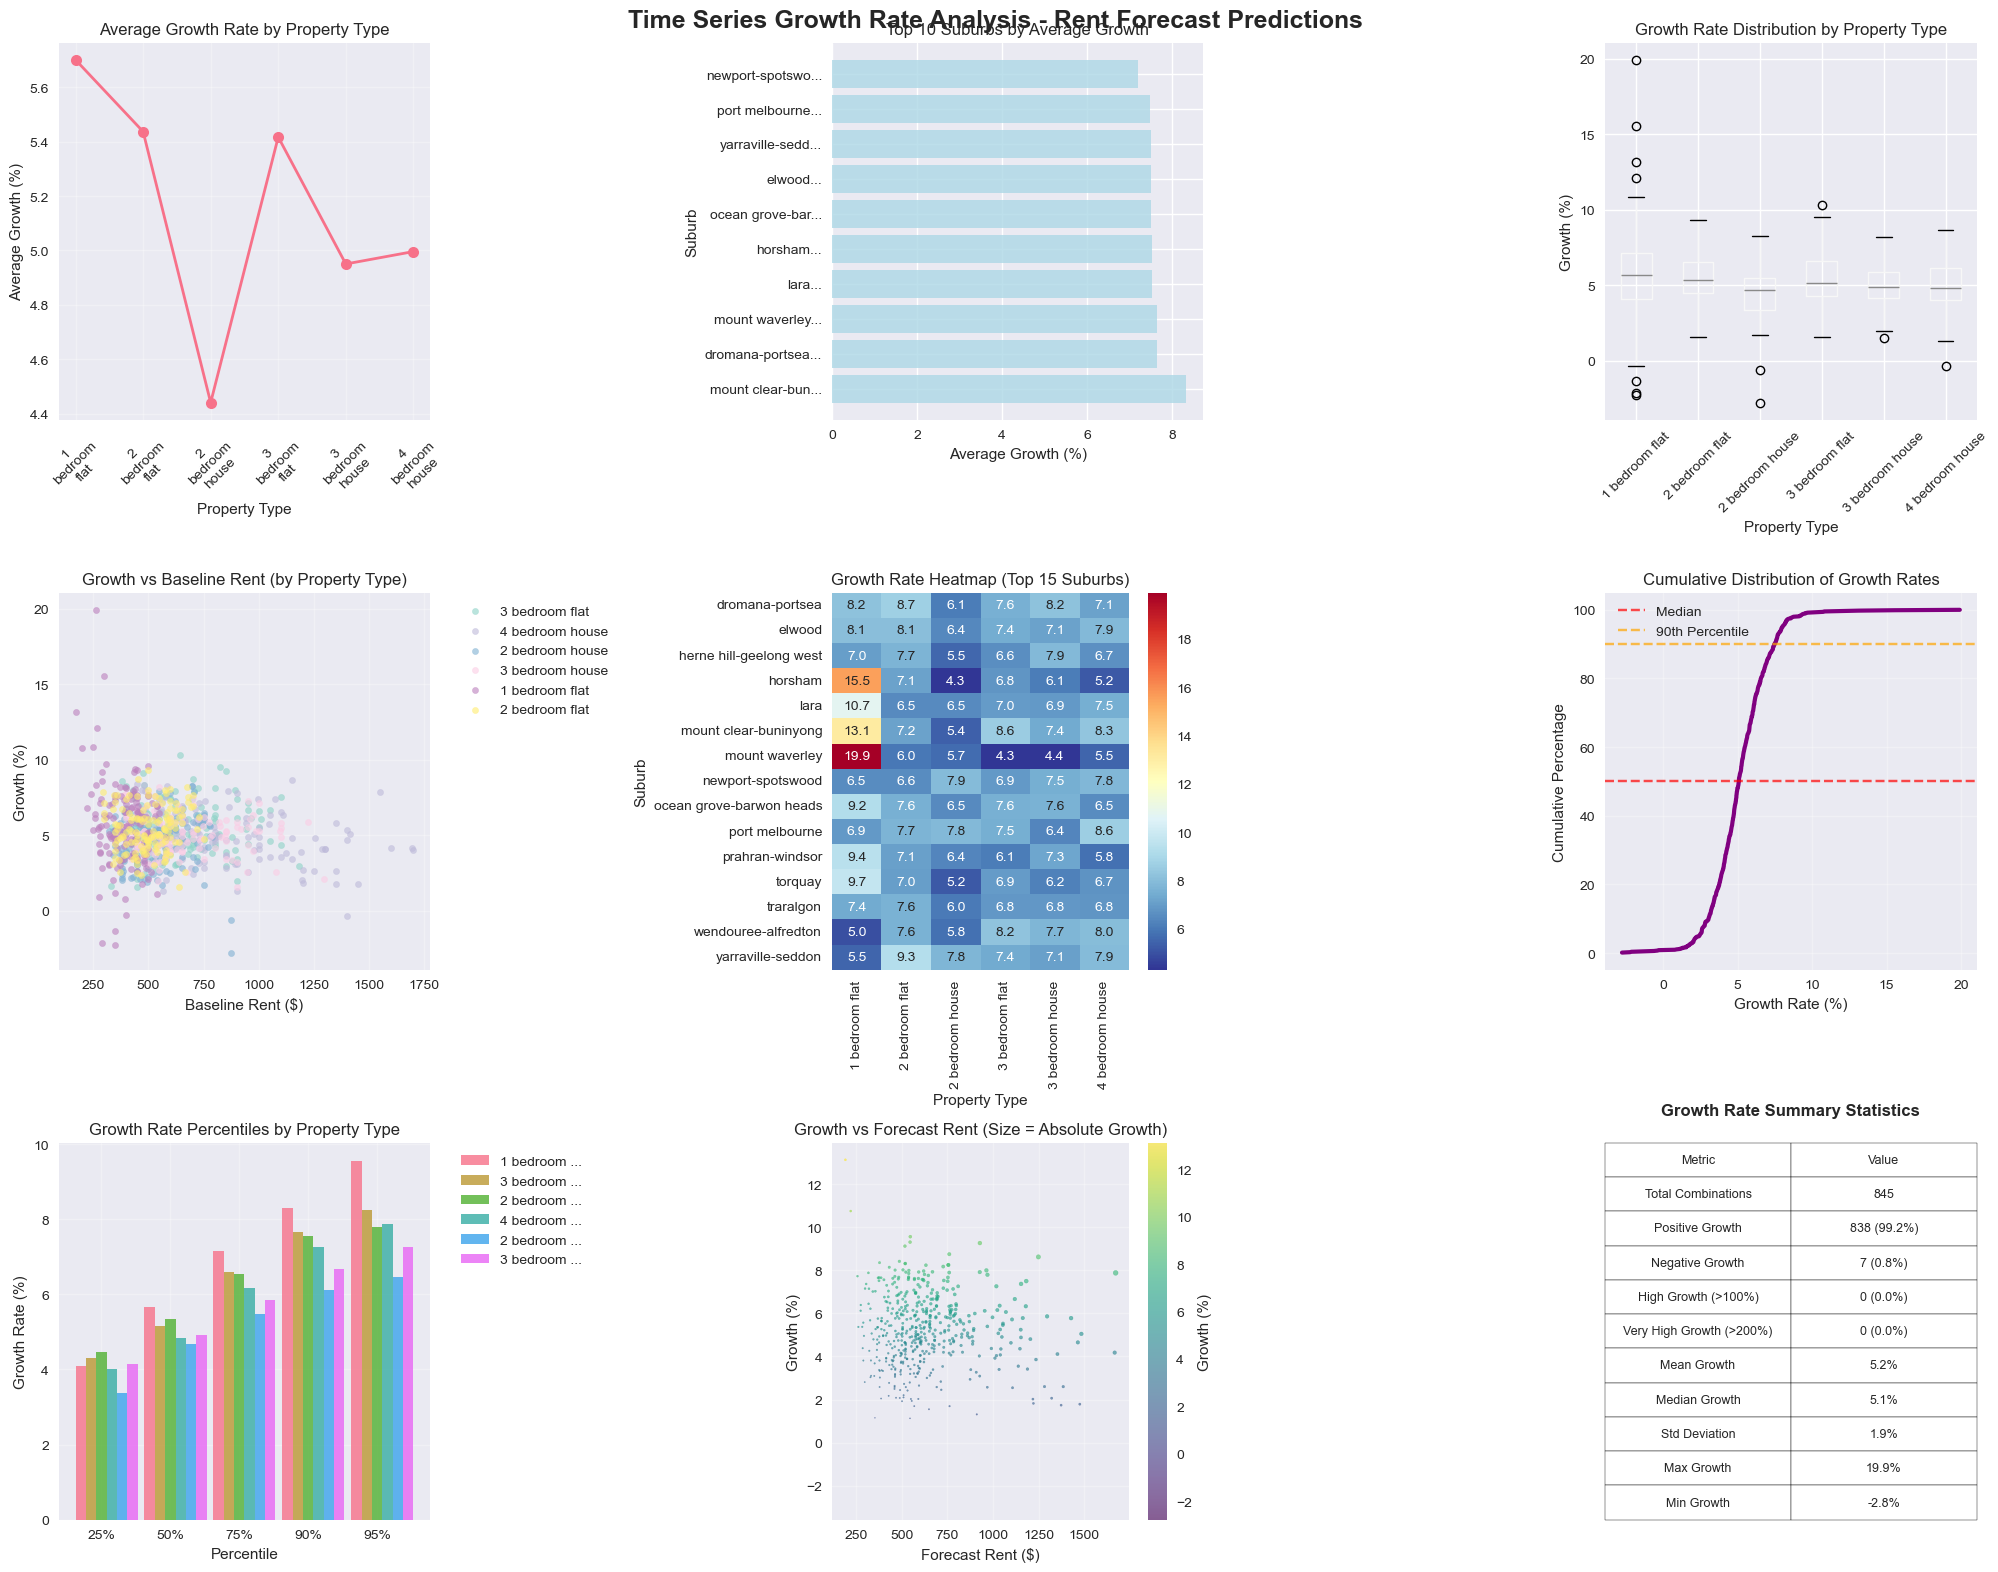

In [76]:
# =============================================================================
# TIME SERIES GROWTH RATE VISUALIZATIONS
# =============================================================================

print("TIME SERIES GROWTH RATE ANALYSIS")
print("=" * 80)

# Create time series growth rate visualisations
fig = plt.figure(figsize=(20, 16))

# 1. Growth Rate Over Time (Quarterly)
plt.subplot(3, 3, 1)
quarterly_growth = rent_growth_df.groupby('property_type')['percentage_growth'].mean()
plt.plot(range(len(quarterly_growth)), quarterly_growth.values, 'o-', linewidth=2, markersize=8)
plt.xlabel('Property Type')
plt.ylabel('Average Growth (%)')
plt.title('Average Growth Rate by Property Type')
plt.xticks(range(len(quarterly_growth)), [pt.replace(' ', '\n') for pt in quarterly_growth.index], rotation=45)
plt.grid(True, alpha=0.3)

# 2. Top 10 Suburbs Growth Over Time
plt.subplot(3, 3, 2)
top_10_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(10)
plt.barh(range(len(top_10_suburbs)), top_10_suburbs.values, color='lightblue', alpha=0.8)
plt.xlabel('Average Growth (%)')
plt.ylabel('Suburb')
plt.title('Top 10 Suburbs by Average Growth')
plt.yticks(range(len(top_10_suburbs)), [sub.replace('_', ' ')[:15] + '...' for sub in top_10_suburbs.index])

# 3. Growth Rate Distribution by Property Type
plt.subplot(3, 3, 3)
rent_growth_df.boxplot(column='percentage_growth', by='property_type', ax=plt.gca())
plt.title('Growth Rate Distribution by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Growth (%)')
plt.xticks(rotation=45)

# 4. Growth Rate vs Baseline Rent
plt.subplot(3, 3, 4)
sample_data = rent_growth_df.sample(min(1000, len(rent_growth_df)))
colors = plt.cm.Set3(np.linspace(0, 1, len(sample_data['property_type'].unique())))
for i, prop_type in enumerate(sample_data['property_type'].unique()):
    prop_data = sample_data[sample_data['property_type'] == prop_type]
    plt.scatter(prop_data['baseline_rent'], prop_data['percentage_growth'], 
               c=[colors[i]], label=prop_type, alpha=0.6, s=20)
plt.xlabel('Baseline Rent ($)')
plt.ylabel('Growth (%)')
plt.title('Growth vs Baseline Rent (by Property Type)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 5. Growth Rate Heatmap
plt.subplot(3, 3, 5)
# Create a pivot table for heatmap
top_15_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(15).index
heatmap_data = rent_growth_df[rent_growth_df['suburb'].isin(top_15_suburbs)].pivot_table(
    values='percentage_growth', index='suburb', columns='property_type', aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=plt.gca())
plt.title('Growth Rate Heatmap (Top 15 Suburbs)')
plt.xlabel('Property Type')
plt.ylabel('Suburb')

# 6. Cumulative Growth Distribution
plt.subplot(3, 3, 6)
sorted_growth = np.sort(rent_growth_df['percentage_growth'])
cumulative_pct = np.arange(1, len(sorted_growth) + 1) / len(sorted_growth) * 100
plt.plot(sorted_growth, cumulative_pct, linewidth=3, color='purple')
plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Median')
plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90th Percentile')
plt.xlabel('Growth Rate (%)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Growth Rates')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Growth Rate Percentiles by Property Type
plt.subplot(3, 3, 7)
percentiles = [25, 50, 75, 90, 95]
prop_percentiles = {}
for prop_type in rent_growth_df['property_type'].unique():
    prop_data = rent_growth_df[rent_growth_df['property_type'] == prop_type]['percentage_growth']
    prop_percentiles[prop_type] = [np.percentile(prop_data, p) for p in percentiles]

x = np.arange(len(percentiles))
width = 0.15
for i, (prop_type, values) in enumerate(prop_percentiles.items()):
    plt.bar(x + i*width, values, width, label=prop_type[:10] + '...', alpha=0.8)

plt.xlabel('Percentile')
plt.ylabel('Growth Rate (%)')
plt.title('Growth Rate Percentiles by Property Type')
plt.xticks(x + width*2, [f'{p}%' for p in percentiles])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 8. Growth Rate vs Forecast Rent
plt.subplot(3, 3, 8)
sample_data = rent_growth_df.sample(min(500, len(rent_growth_df)))
scatter = plt.scatter(sample_data['forecast_rent'], sample_data['percentage_growth'], 
                     s=sample_data['absolute_growth']/10, alpha=0.6, c=sample_data['percentage_growth'], 
                     cmap='viridis')
plt.xlabel('Forecast Rent ($)')
plt.ylabel('Growth (%)')
plt.title('Growth vs Forecast Rent (Size = Absolute Growth)')
plt.colorbar(scatter, label='Growth (%)')
plt.grid(True, alpha=0.3)

# 9. Summary Statistics Table
plt.subplot(3, 3, 9)
plt.axis('off')

# Calculate additional statistics
total_combinations = len(rent_growth_df)
positive_growth = (rent_growth_df['percentage_growth'] > 0).sum()
negative_growth = (rent_growth_df['percentage_growth'] < 0).sum()
high_growth = (rent_growth_df['percentage_growth'] > 100).sum()
very_high_growth = (rent_growth_df['percentage_growth'] > 200).sum()

summary_stats = [
    ['Metric', 'Value'],
    ['Total Combinations', f"{total_combinations:,}"],
    ['Positive Growth', f"{positive_growth:,} ({100*positive_growth/total_combinations:.1f}%)"],
    ['Negative Growth', f"{negative_growth:,} ({100*negative_growth/total_combinations:.1f}%)"],
    ['High Growth (>100%)', f"{high_growth:,} ({100*high_growth/total_combinations:.1f}%)"],
    ['Very High Growth (>200%)', f"{very_high_growth:,} ({100*very_high_growth/total_combinations:.1f}%)"],
    ['Mean Growth', f"{rent_growth_df['percentage_growth'].mean():.1f}%"],
    ['Median Growth', f"{rent_growth_df['percentage_growth'].median():.1f}%"],
    ['Std Deviation', f"{rent_growth_df['percentage_growth'].std():.1f}%"],
    ['Max Growth', f"{rent_growth_df['percentage_growth'].max():.1f}%"],
    ['Min Growth', f"{rent_growth_df['percentage_growth'].min():.1f}%"]
]

summary_table = plt.table(cellText=summary_stats, colLabels=None, 
                          cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
summary_table.auto_set_font_size(False)
summary_table.set_fontsize(9)
summary_table.scale(1, 1.2)
plt.title('Growth Rate Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.suptitle('Time Series Growth Rate Analysis - Rent Forecast Predictions', fontsize=18, fontweight='bold', y=0.98)


plt.show()


GEOGRAPHIC GROWTH RATE ANALYSIS


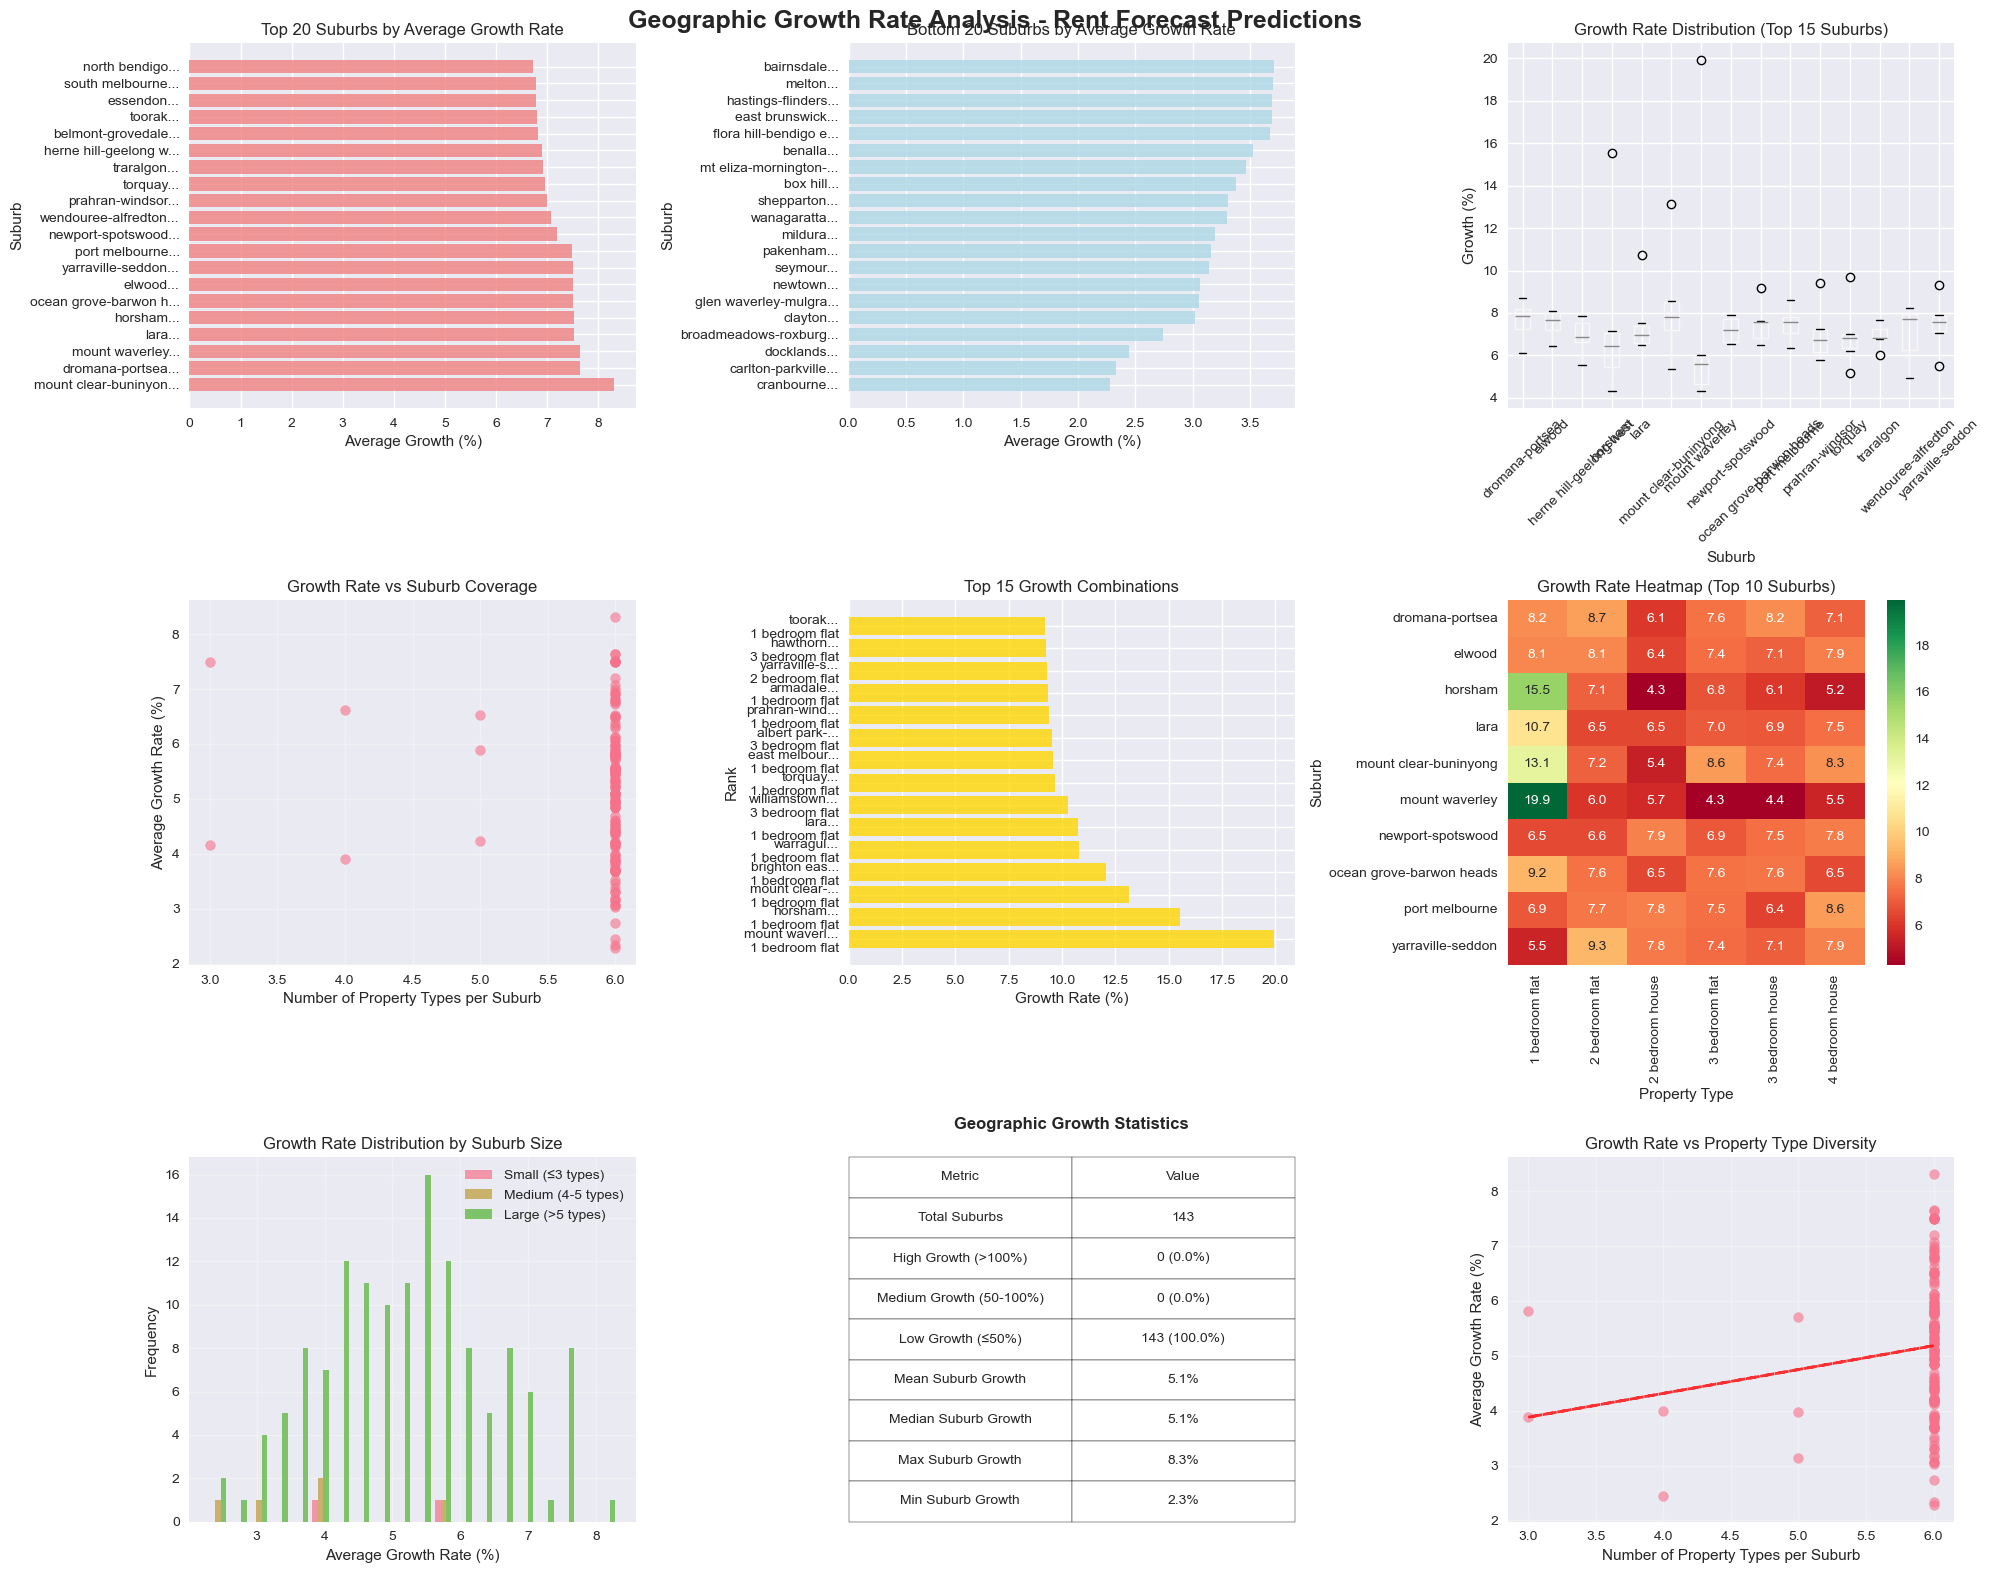


GEOGRAPHIC GROWTH RATE SUMMARY
Total suburbs analyzed: 143
High growth suburbs (>100%): 0 (0.0%)
Medium growth suburbs (50-100%): 0 (0.0%)
Low growth suburbs (≤50%): 143 (100.0%)
Average growth rate per suburb: 5.1%
Median growth rate per suburb: 5.1%


In [77]:
# =============================================================================
# GEOGRAPHIC GROWTH RATE VISUALISATIONS
# =============================================================================

print("GEOGRAPHIC GROWTH RATE ANALYSIS")
print("=" * 80)

# Create geographic growth rate visualisations
fig = plt.figure(figsize=(20, 16))

# 1. Top 20 Suburbs by Growth Rate
plt.subplot(3, 3, 1)
top_20_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(20)
plt.barh(range(len(top_20_suburbs)), top_20_suburbs.values, color='lightcoral', alpha=0.8)
plt.xlabel('Average Growth (%)')
plt.ylabel('Suburb')
plt.title('Top 20 Suburbs by Average Growth Rate')
plt.yticks(range(len(top_20_suburbs)), [sub.replace('_', ' ')[:20] + '...' for sub in top_20_suburbs.index])

# 2. Bottom 20 Suburbs by Growth Rate
plt.subplot(3, 3, 2)
bottom_20_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nsmallest(20)
plt.barh(range(len(bottom_20_suburbs)), bottom_20_suburbs.values, color='lightblue', alpha=0.8)
plt.xlabel('Average Growth (%)')
plt.ylabel('Suburb')
plt.title('Bottom 20 Suburbs by Average Growth Rate')
plt.yticks(range(len(bottom_20_suburbs)), [sub.replace('_', ' ')[:20] + '...' for sub in bottom_20_suburbs.index])

# 3. Growth Rate Distribution by Suburb
plt.subplot(3, 3, 3)
# Sample top 15 suburbs for box plot
top_15_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(15).index
sample_data = rent_growth_df[rent_growth_df['suburb'].isin(top_15_suburbs)]
sample_data.boxplot(column='percentage_growth', by='suburb', ax=plt.gca())
plt.title('Growth Rate Distribution (Top 15 Suburbs)')
plt.xlabel('Suburb')
plt.ylabel('Growth (%)')
plt.xticks(rotation=45)

# 4. Growth Rate vs Suburb Count
plt.subplot(3, 3, 4)
suburb_counts = rent_growth_df['suburb'].value_counts()
suburb_avg_growth = rent_growth_df.groupby('suburb')['percentage_growth'].mean()
plt.scatter(suburb_counts, suburb_avg_growth, alpha=0.6, s=50)
plt.xlabel('Number of Property Types per Suburb')
plt.ylabel('Average Growth Rate (%)')
plt.title('Growth Rate vs Suburb Coverage')
plt.grid(True, alpha=0.3)

# 5. Top Growth Combinations by Suburb
plt.subplot(3, 3, 5)
top_combinations = rent_growth_df.nlargest(15, 'percentage_growth')
plt.barh(range(len(top_combinations)), top_combinations['percentage_growth'], color='gold', alpha=0.8)
plt.xlabel('Growth Rate (%)')
plt.ylabel('Rank')
plt.title('Top 15 Growth Combinations')
plt.yticks(range(len(top_combinations)), 
           [f"{row['suburb'][:12]}...\n{row['property_type']}" for _, row in top_combinations.iterrows()])

# 6. Growth Rate Heatmap - Top Suburbs vs Property Types
plt.subplot(3, 3, 6)
top_10_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().nlargest(10).index
heatmap_data = rent_growth_df[rent_growth_df['suburb'].isin(top_10_suburbs)].pivot_table(
    values='percentage_growth', index='suburb', columns='property_type', aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=plt.gca())
plt.title('Growth Rate Heatmap (Top 10 Suburbs)')
plt.xlabel('Property Type')
plt.ylabel('Suburb')

# 7. Growth Rate Distribution by Suburb Size
plt.subplot(3, 3, 7)
suburb_sizes = rent_growth_df['suburb'].value_counts()
suburb_avg_growth = rent_growth_df.groupby('suburb')['percentage_growth'].mean()

# Categorize suburbs by size
small_suburbs = suburb_sizes[suburb_sizes <= 3].index
medium_suburbs = suburb_sizes[(suburb_sizes > 3) & (suburb_sizes <= 5)].index
large_suburbs = suburb_sizes[suburb_sizes > 5].index

small_growth = suburb_avg_growth[small_suburbs]
medium_growth = suburb_avg_growth[medium_suburbs]
large_growth = suburb_avg_growth[large_suburbs]

plt.hist([small_growth, medium_growth, large_growth], 
         bins=20, alpha=0.7, label=['Small (≤3 types)', 'Medium (4-5 types)', 'Large (>5 types)'])
plt.xlabel('Average Growth Rate (%)')
plt.ylabel('Frequency')
plt.title('Growth Rate Distribution by Suburb Size')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Geographic Growth Rate Statistics
plt.subplot(3, 3, 8)
plt.axis('off')

# Calculate geographic statistics
total_suburbs = rent_growth_df['suburb'].nunique()
high_growth_suburbs = (suburb_avg_growth > 100).sum()
medium_growth_suburbs = ((suburb_avg_growth > 50) & (suburb_avg_growth <= 100)).sum()
low_growth_suburbs = (suburb_avg_growth <= 50).sum()

geo_stats = [
    ['Metric', 'Value'],
    ['Total Suburbs', f"{total_suburbs:,}"],
    ['High Growth (>100%)', f"{high_growth_suburbs:,} ({100*high_growth_suburbs/total_suburbs:.1f}%)"],
    ['Medium Growth (50-100%)', f"{medium_growth_suburbs:,} ({100*medium_growth_suburbs/total_suburbs:.1f}%)"],
    ['Low Growth (≤50%)', f"{low_growth_suburbs:,} ({100*low_growth_suburbs/total_suburbs:.1f}%)"],
    ['Mean Suburb Growth', f"{suburb_avg_growth.mean():.1f}%"],
    ['Median Suburb Growth', f"{suburb_avg_growth.median():.1f}%"],
    ['Max Suburb Growth', f"{suburb_avg_growth.max():.1f}%"],
    ['Min Suburb Growth', f"{suburb_avg_growth.min():.1f}%"]
]

geo_table = plt.table(cellText=geo_stats, colLabels=None, 
                      cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
geo_table.auto_set_font_size(False)
geo_table.set_fontsize(10)
geo_table.scale(1, 1.2)
plt.title('Geographic Growth Statistics', fontsize=12, fontweight='bold', pad=20)

# 9. Growth Rate vs Property Type Count per Suburb
plt.subplot(3, 3, 9)
suburb_property_counts = rent_growth_df.groupby('suburb')['property_type'].nunique()
plt.scatter(suburb_property_counts, suburb_avg_growth, alpha=0.6, s=50)
plt.xlabel('Number of Property Types per Suburb')
plt.ylabel('Average Growth Rate (%)')
plt.title('Growth Rate vs Property Type Diversity')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(suburb_property_counts, suburb_avg_growth, 1)
p = np.poly1d(z)
plt.plot(suburb_property_counts, p(suburb_property_counts), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.suptitle('Geographic Growth Rate Analysis - Rent Forecast Predictions', fontsize=18, fontweight='bold', y=0.98)


plt.show()

# Print summary of geographic analysis
print("\n" + "=" * 80)
print("GEOGRAPHIC GROWTH RATE SUMMARY")
print("=" * 80)
print(f"Total suburbs analyzed: {total_suburbs:,}")
print(f"High growth suburbs (>100%): {high_growth_suburbs:,} ({100*high_growth_suburbs/total_suburbs:.1f}%)")
print(f"Medium growth suburbs (50-100%): {medium_growth_suburbs:,} ({100*medium_growth_suburbs/total_suburbs:.1f}%)")
print(f"Low growth suburbs (≤50%): {low_growth_suburbs:,} ({100*low_growth_suburbs/total_suburbs:.1f}%)")
print(f"Average growth rate per suburb: {suburb_avg_growth.mean():.1f}%")
print(f"Median growth rate per suburb: {suburb_avg_growth.median():.1f}%")
print("=" * 80)


TOP 10 SUBURBS BY GROWTH RATE


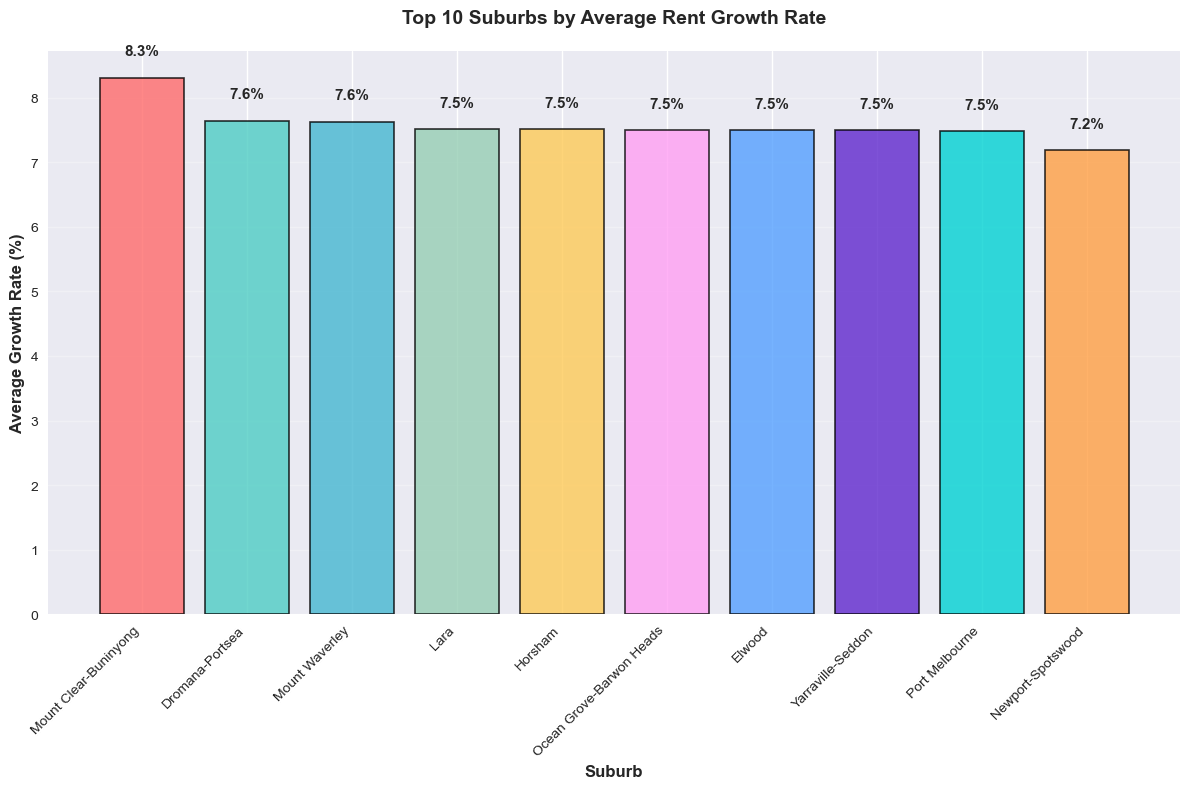


TOP 10 SUBURBS BY GROWTH RATE:
----------------------------------------
 1. Mount Clear-Buninyong: 8.3%
 2. Dromana-Portsea: 7.6%
 3. Mount Waverley: 7.6%
 4. Lara: 7.5%
 5. Horsham: 7.5%
 6. Ocean Grove-Barwon Heads: 7.5%
 7. Elwood: 7.5%
 8. Yarraville-Seddon: 7.5%
 9. Port Melbourne: 7.5%
10. Newport-Spotswood: 7.2%

TOP 10 STATISTICS:
Average growth rate: 7.6%
Highest growth: 8.3%
Lowest in top 10: 7.2%
Standard deviation: 0.3%


In [78]:
# Create a bar chart of the top 10 suburbs by growth rate
import matplotlib.pyplot as plt
import numpy as np

print("TOP 10 SUBURBS BY GROWTH RATE")
print("=" * 40)

# Get top 10 suburbs by average growth rate
top_10_suburbs = rent_growth_df.groupby('suburb')['percentage_growth'].mean().sort_values(ascending=False).head(10)


# Create the figure
plt.figure(figsize=(12, 8))

# Create the bar chart
bars = plt.bar(range(len(top_10_suburbs)), top_10_suburbs.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43'],
               alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the chart
plt.xlabel('Suburb', fontsize=12, fontweight='bold')
plt.ylabel('Average Growth Rate (%)', fontsize=12, fontweight='bold')
plt.title('Top 10 Suburbs by Average Rent Growth Rate', fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels
plt.xticks(range(len(top_10_suburbs)), 
           [suburb.replace('_', ' ').title() for suburb in top_10_suburbs.index], 
           rotation=45, ha='right')

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, top_10_suburbs.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add grid for better readability
plt.grid(True, alpha=0.3, axis='y')
plt.gca().set_axisbelow(True)

# Add summary statistics as text
stats_text = f"""
Top 10 Summary:
• Highest Growth: {top_10_suburbs.iloc[0]:.1f}%
• Lowest in Top 10: {top_10_suburbs.iloc[-1]:.1f}%
• Average of Top 10: {top_10_suburbs.mean():.1f}%
• Range: {top_10_suburbs.iloc[-1]:.1f}% - {top_10_suburbs.iloc[0]:.1f}%
"""

# plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
      #   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
       #  fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print the top 10 suburbs
print("\nTOP 10 SUBURBS BY GROWTH RATE:")
print("-" * 40)
for i, (suburb, growth_rate) in enumerate(top_10_suburbs.items(), 1):
    print(f"{i:2d}. {suburb.replace('_', ' ').title()}: {growth_rate:.1f}%")

print(f"\nTOP 10 STATISTICS:")
print(f"Average growth rate: {top_10_suburbs.mean():.1f}%")
print(f"Highest growth: {top_10_suburbs.iloc[0]:.1f}%")
print(f"Lowest in top 10: {top_10_suburbs.iloc[-1]:.1f}%")
print(f"Standard deviation: {top_10_suburbs.std():.1f}%")


GROWTH RATES BY SUBURB-PROPERTY TYPE COMBINATIONS


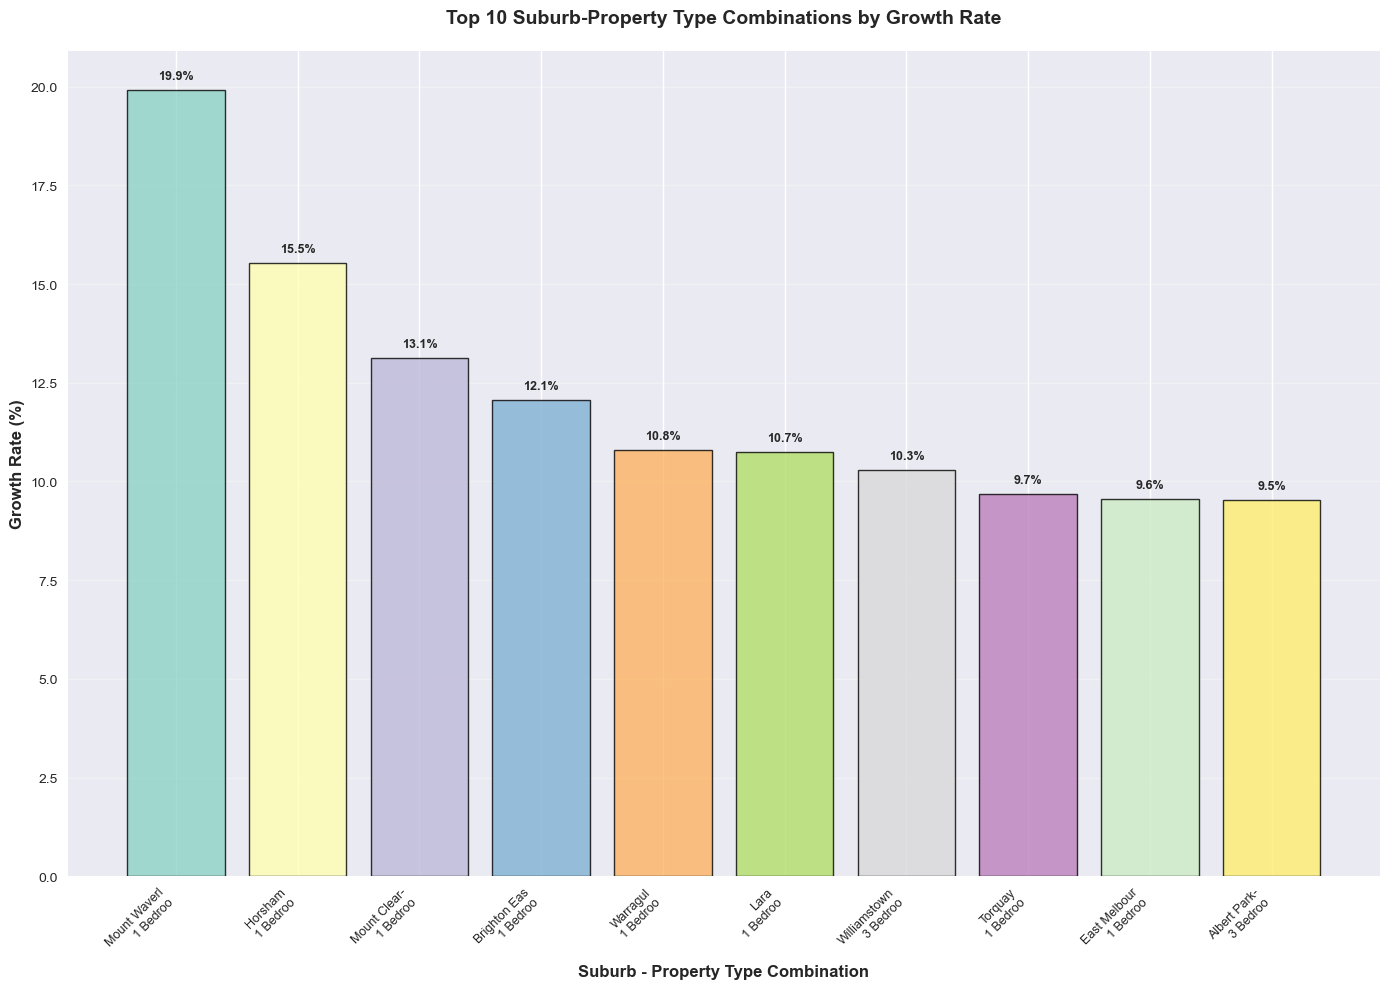


TOP 10 SUBURB-PROPERTY TYPE COMBINATIONS:
------------------------------------------------------------
 1. Mount Waverley - 1 Bedroom Flat: 19.9%
 2. Horsham - 1 Bedroom Flat: 15.5%
 3. Mount Clear-Buninyong - 1 Bedroom Flat: 13.1%
 4. Brighton East - 1 Bedroom Flat: 12.1%
 5. Warragul - 1 Bedroom Flat: 10.8%
 6. Lara - 1 Bedroom Flat: 10.7%
 7. Williamstown - 3 Bedroom Flat: 10.3%
 8. Torquay - 1 Bedroom Flat: 9.7%
 9. East Melbourne - 1 Bedroom Flat: 9.6%
10. Albert Park-Middle Park-West St Kilda - 3 Bedroom Flat: 9.5%

TOP 10 STATISTICS:
Average growth rate: 12.1%
Highest growth: 19.9%
Lowest in top 15: 9.5%
Standard deviation: 3.3%


In [79]:
# Create a bar chart of growth rates by suburb-property type combinations
import matplotlib.pyplot as plt
import numpy as np

print("GROWTH RATES BY SUBURB-PROPERTY TYPE COMBINATIONS")
print("=" * 60)

# Get top 10 suburb-property type combinations by growth rate
combo_growth = rent_growth_df.groupby(['suburb', 'property_type'])['percentage_growth'].mean().sort_values(ascending=False).head(10)


# Create the figure
plt.figure(figsize=(14, 10))

# Create the bar chart
bars = plt.bar(range(len(combo_growth)), combo_growth.values, 
               color=plt.cm.Set3(np.linspace(0, 1, len(combo_growth))),
               alpha=0.8, edgecolor='black', linewidth=1.0)

# Customize the chart
plt.xlabel('Suburb - Property Type Combination', fontsize=12, fontweight='bold')
plt.ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
plt.title('Top 10 Suburb-Property Type Combinations by Growth Rate', fontsize=14, fontweight='bold', pad=20)

# Create labels for x-axis
combo_labels = []
for suburb, prop_type in combo_growth.index:
    suburb_clean = suburb.replace('_', ' ').title()[:12]  # Limit suburb name length
    prop_type_clean = prop_type.replace('_', ' ').title()[:8]  # Limit property type length
    combo_labels.append(f"{suburb_clean}\n{prop_type_clean}")

# Set x-axis labels
plt.xticks(range(len(combo_growth)), combo_labels, rotation=45, ha='right', fontsize=9)

for i, (bar, value) in enumerate(zip(bars, combo_growth.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add grid 
plt.grid(True, alpha=0.3, axis='y')
plt.gca().set_axisbelow(True)


plt.tight_layout()
plt.show()

# Print the top 10 combinations
print("\nTOP 10 SUBURB-PROPERTY TYPE COMBINATIONS:")
print("-" * 60)
for i, ((suburb, prop_type), growth_rate) in enumerate(combo_growth.items(), 1):
    print(f"{i:2d}. {suburb.replace('_', ' ').title()} - {prop_type.replace('_', ' ').title()}: {growth_rate:.1f}%")

print(f"\nTOP 10 STATISTICS:")
print(f"Average growth rate: {combo_growth.mean():.1f}%")
print(f"Highest growth: {combo_growth.iloc[0]:.1f}%")
print(f"Lowest in top 15: {combo_growth.iloc[-1]:.1f}%")
print(f"Standard deviation: {combo_growth.std():.1f}%")



DISTRIBUTION OF PREDICTED RENTS


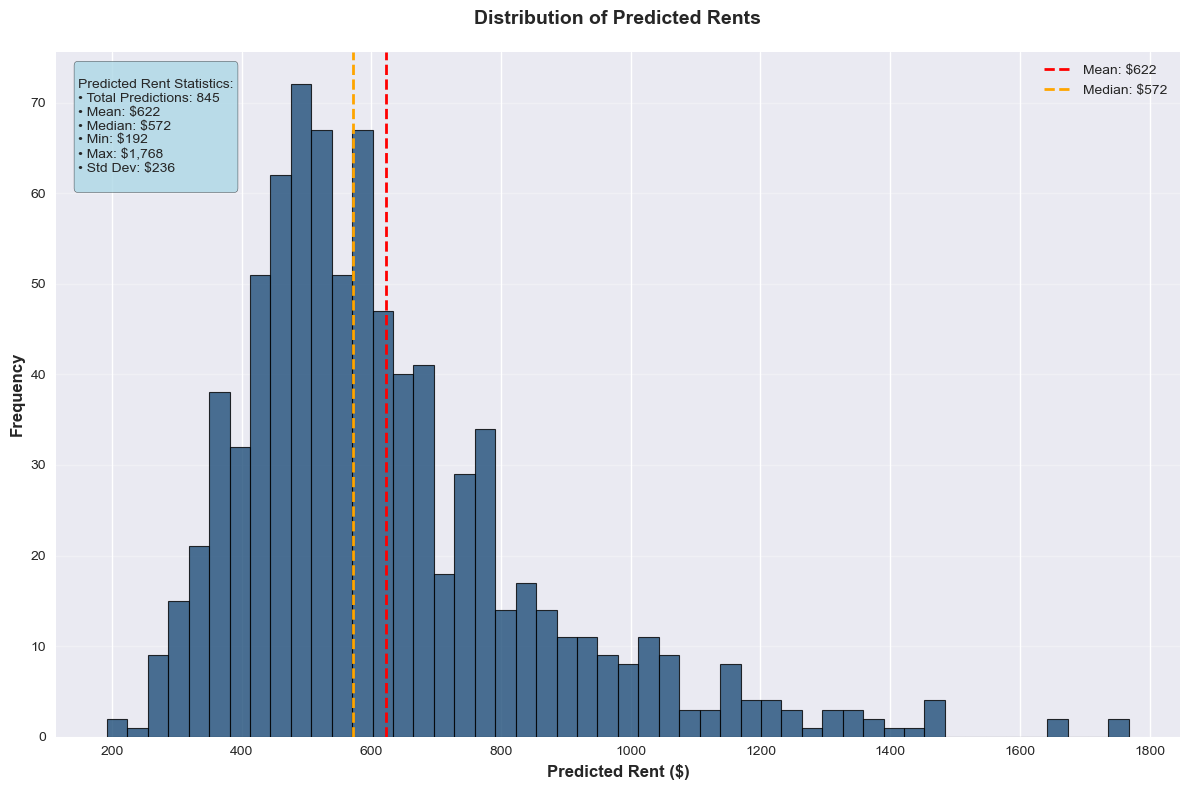


PREDICTED RENT STATISTICS:
Total predictions: 845
Mean predicted rent: $622
Median predicted rent: $572
Standard deviation: $236
Minimum predicted rent: $192
Maximum predicted rent: $1,768
25th percentile: $466
75th percentile: $728


In [80]:
# Create a histogram of predicted rents distribution
import matplotlib.pyplot as plt
import numpy as np

print("DISTRIBUTION OF PREDICTED RENTS")
print("=" * 40)

# Create the figure
plt.figure(figsize=(12, 8))

# Create histogram of predicted rents
plt.hist(rent_growth_df['forecast_rent'], bins=50, alpha=0.8, 
         color='#1f4e79', edgecolor='black', linewidth=0.8)

# Customise the chart
plt.xlabel('Predicted Rent ($)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Predicted Rents', fontsize=14, fontweight='bold', pad=20)

# Add vertical lines for mean and median
mean_rent = rent_growth_df['forecast_rent'].mean()
median_rent = rent_growth_df['forecast_rent'].median()

plt.axvline(mean_rent, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${mean_rent:,.0f}')
plt.axvline(median_rent, color='orange', linestyle='--', linewidth=2, 
            label=f'Median: ${median_rent:,.0f}')

# Add legend
plt.legend(fontsize=10)

# Add grid 
plt.grid(True, alpha=0.3, axis='y')
plt.gca().set_axisbelow(True)

# Add summary statistics as text
stats_text = f"""
Predicted Rent Statistics:
• Total Predictions: {len(rent_growth_df):,}
• Mean: ${mean_rent:,.0f}
• Median: ${median_rent:,.0f}
• Min: ${rent_growth_df['forecast_rent'].min():,.0f}
• Max: ${rent_growth_df['forecast_rent'].max():,.0f}
• Std Dev: ${rent_growth_df['forecast_rent'].std():,.0f}
"""

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nPREDICTED RENT STATISTICS:")
print(f"Total predictions: {len(rent_growth_df):,}")
print(f"Mean predicted rent: ${mean_rent:,.0f}")
print(f"Median predicted rent: ${median_rent:,.0f}")
print(f"Standard deviation: ${rent_growth_df['forecast_rent'].std():,.0f}")
print(f"Minimum predicted rent: ${rent_growth_df['forecast_rent'].min():,.0f}")
print(f"Maximum predicted rent: ${rent_growth_df['forecast_rent'].max():,.0f}")
print(f"25th percentile: ${rent_growth_df['forecast_rent'].quantile(0.25):,.0f}")
print(f"75th percentile: ${rent_growth_df['forecast_rent'].quantile(0.75):,.0f}")
